Implement 2 NN
1. MLP with 3 hidden layers
2. CNN with 2 convolutional layers: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


For each NN, explore the following training hyperparameters:
1. Adaptive Learning Rate Scheduling Methods: Power and Exponential Scheduling
2. Activation Functions: ReLu (good for all hidden layers), Sigmoid, Leaky ReLu
3. Optimizers: SGD, ADAM, RMSProp
4. With vs Without Batch Normalization
5. Without L1&L2 regularization, with L1 regularization, with L2 regularization
6. With vs Without Dropout

a. Number of Hidden Layers </br>
b. Number of hidden neurons for each hidden layers
    Good guideline of choosing number of hidden neurons: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

This link is essentially our project but uses keras instead of pytorch: https://devskrol.com/2021/12/22/advanced-hyperparameter-tuning-of-a-multilayer-perceptron-mlp/

Cross validation: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

However depending upon the properties of the problem we might be able to make a better choice for easy and quicker convergence of the network.

Sigmoid functions and their combinations generally work better in the case of classifiers
Sigmoids and tanh functions are sometimes avoided due to the vanishing gradient problem
ReLU function is a general activation function and is used in most cases these days
If we encounter a case of dead neurons in our networks the leaky ReLU function is the best choice
Always keep in mind that ReLU function should only be used in the hidden layers
As a rule of thumb, you can begin with using ReLU function and then move over to other activation functions in case ReLU doesn’t provide with optimum results

## 1. Importing the Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import time
import random

## 2. Loading the Dataset

In [2]:
# Loading dataset
trainSet = torchvision.datasets.EMNIST(root = './data/EMNIST', split='balanced', download = True,
                                              train = True, transform = transforms.Compose([transforms.ToTensor(),]))

testSet = torchvision.datasets.EMNIST(root = './data/EMNIST', split='balanced',download=True,
                                             train=False, transform = transforms.Compose([transforms.ToTensor()]))

print(trainSet)
print(testSet)

Dataset EMNIST
    Number of datapoints: 112800
    Root location: ./data/EMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset EMNIST
    Number of datapoints: 18800
    Root location: ./data/EMNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [8]:
!pip install skorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold

import time
import random

from skorch import NeuralNetClassifier
# Loading dataset
trainSet = torchvision.datasets.EMNIST(root = './data/EMNIST', split='balanced', download = True,
                                              train = True, transform = transforms.Compose([transforms.ToTensor(),]))

testSet = torchvision.datasets.EMNIST(root = './data/EMNIST', split='balanced',download=True,
                                             train=False, transform = transforms.Compose([transforms.ToTensor()]))

# the images are already of the type 'tensor'

print(trainSet)
print(testSet)
# dataloader
trainLoader = DataLoader(trainSet,batch_size=128)

testLoader = DataLoader(testSet,batch_size=60000)

# iterate the train data with samples
images, labels = next(iter(trainLoader))

# 3 Hidden Layers
class MLP(nn.Module):
    def __init__(self, model):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = model

    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

    def compute_l1(self, weights):
        return torch.abs(weights).sum()

    def compute_l2(self, weights):
        return torch.square(weights).sum()

def resetting_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer {layer}')
            layer.reset_parameters()

inputSize = 28*28
outputSize = 47
hiddenSize = 392

lr = 0.005   # learning rate

lossCriteria = nn.CrossEntropyLoss()

# setting seeds so as to minimise the sources of randomness in the program
torch.manual_seed(7)
random.seed(7)
np.random.seed(7)

n_epochs = 10
n_folds = 5
kfold = KFold(n_splits = n_folds, shuffle = True)

     -------------------------------------- 193.7/193.7 kB 3.0 MB/s eta 0:00:00
Dataset EMNIST
    Number of datapoints: 112800
    Root location: ./data/EMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset EMNIST
    Number of datapoints: 18800
    Root location: ./data/EMNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [9]:
## 3 Layers
inputSize = 28*28
outputSize = 47
hiddenSize = 392

class MLP(nn.Module):
    def __init__(self, model):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = model

    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

    def compute_l1(self, weights):
        return torch.abs(weights).sum()

    def compute_l2(self, weights):
        return torch.square(weights).sum()

finalModelMLP3 = nn.Sequential(
    nn.BatchNorm1d(inputSize), # here, batchnorm is done to normalise the input which can also be done as a separate step after loading of the data
    nn.Linear(inputSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, outputSize, bias = False)
)

accuracies_lr = [] # to store accuracies of each fold

# iterating through each fold
for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
    print(f'\nFold #{i+1}\n------------------------')

    # taking random data objects with no replacement 
    train_sampler = SubsetRandomSampler(train_id)
    val_sampler = SubsetRandomSampler(val_id)

    # creating dataloader objects for training and validation data in this fold
    train_fold = DataLoader(trainSet, batch_size=128, sampler=train_sampler)
    val_fold = DataLoader(trainSet, batch_size=128, sampler=val_sampler)

    # initialising the model and the optimiser
    mlp_schedulers = MLP(finalModelMLP3)
    mlp_schedulers.apply(resetting_weights)
    optimizer_lr = optim.Adam(mlp_schedulers.parameters(), lr=0.05)

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer_lr, gamma=0.825)

    accu_fold = []

    # training for a certain number of epochs
    for epoch in range(n_epochs):

        start = time.time() # noting the starting time

        # print(f'\n\t Epoch: {epoch+1}')

        loss = 0
        totalTrain, correct_train_preds = 0, 0
        totalVal, correct_val_preds = 0, 0

        # here, we have taken a fold, and in that fold we have taken an epoch of training, and in that we are going to traverse through all the batches of data and train the model
        for batch, (images, labels) in enumerate(train_fold):

            optimizer_lr.zero_grad()

            # training the images in this batch and getting accuracy
            output_train = mlp_schedulers(images)

            train_values, train_pred_labels = torch.max(output_train.data, 1)
            totalTrain += labels.size(0)

            correct_train_preds += (labels == train_pred_labels).sum().item() 

            # calculating the loss
            current_loss = lossCriteria(output_train, labels)   

            # backprop
            current_loss.backward()

            # optimising the gradients
            optimizer_lr.step()

            lr = optimizer_lr.param_groups[0]['lr']

            # adding the loss to the overall loss
            loss += current_loss.item()
            if batch % 100 == 99:
                # print(f'Loss after mini_batch {batch+1}: {loss/3000}')
                loss = 0

        train_accu = (100 * correct_train_preds) / totalTrain

        # # training of this fold complete
        # print('\nTraining of this fold is complete!')

        end = time.time()   # noting the ending time for a training session
        
    # testing the model obtained in this fold

        with torch.no_grad():
            for batch, (images, labels) in enumerate(val_fold):

                output_val = mlp_schedulers(images)

                # max() returns a paired tuple for each row where the first value is the max value present in that row, and the second value is the index of that max value (like argmax) 
                values, pred_labels = torch.max(output_val.data, 1)
                totalVal += labels.size(0)
                correct_val_preds += (labels == pred_labels).sum().item()

        # calculating val accuracy for the epoch
        val_accu = (correct_val_preds * 100) / totalVal 
        # print(f'Accuracy of Fold {i+1}: {round(accuracy, 4)}\n')
        accu_fold.append(val_accu)

        print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}   Learning Rate: {lr}')
        print(f'Time taken for training fold: {end - start} seconds')

        scheduler.step() # updating the learning rate

    # printing the val accuracy of the fold
    print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
    accuracies_lr.append(accu_fold[-1])

# calculating the mean accuracy of the base model across all folds
mean_accu = np.mean(accuracies_lr)

print(f'\n\n Mean Accuracy of Model with 4 hidden layers: {mean_accu}\n\n')


Fold #1
------------------------


NameError: name 'model_batchnorm' is not defined

## 3. Visualising the Dataset

How some of the images-label look like can be seen here too: https://www.simonwenkel.com/notes/ai/datasets/vision/EMNIST.html#emnist-balanced

In [4]:
emnistLabels={
0: 48,
1: 49,
2: 50,
3: 51,
4: 52,
5: 53,
6: 54,
7: 55,
8: 56,
9: 57,
10: 65,
11: 66,
12: 67,
13: 68,
14: 69,
15: 70,
16: 71,
17: 72,
18: 73,
19: 74,
20: 75,
21: 76,
22: 77,
23: 78,
24: 79,
25: 80,
26: 81,
27: 82,
28: 83,
29: 84,
30: 85,
31: 86,
32: 87,
33: 88,
34: 89,
35: 90,
36: 97,
37: 98,
38: 100,
39: 101,
40: 102,
41: 103,
42: 104,
43: 110,
44: 113,
45: 114,
46: 116,
}

mapasciiDict = {}

for image in range(127):
    mapasciiDict[image] = chr(image)

datadf = pd.Series(emnistLabels).to_frame().reset_index()
datadf = datadf.rename(columns={'index':'ascii',0:'labels'})

mappedDf = pd.Series(mapasciiDict).to_frame().reset_index()
mappedDf = mappedDf.rename(columns={'index':'ascii', 0:'chars'})

mapdataDict = pd.merge(datadf, mappedDf, how="inner", left_on='labels', right_on='ascii')

mapdataDict = mapdataDict.drop(['labels','ascii_y'], axis=1)

mapDict=dict(zip(mapdataDict.ascii_x, mapdataDict.chars))

# Visulize some figures
figure = plt.figure(figsize=(6, 6))
cols, rows = 6,6
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainSet), size=(1,)).item()
    img, label = trainSet[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Ground Truth:{}".format(mapDict[label]), fontsize= 5)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show()

## 4. DataLoader for splitting the dataset

When the batch size is set to one, the training algorithm is referred to as stochastic gradient descent. Likewise, when the batch size is greater than one but less than the size of the entire training data, the training algorithm is known as mini-batch gradient descent. For simplicity, let’s train with stochastic gradient descent and DataLoader.

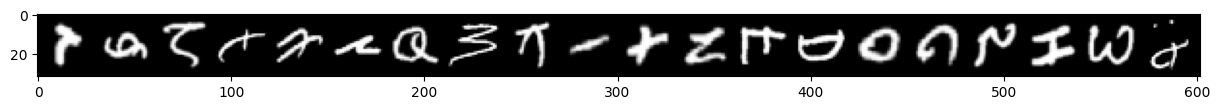

In [79]:
# dataloader
trainLoader = DataLoader(trainSet,batch_size=20)

testLoader = DataLoader(testSet,batch_size=60000)

# iterate the train data with samples
images, labels = next(iter(trainLoader))

#used to create a grid of images
grid = torchvision.utils.make_grid(images,nrow=20)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)),cmap='gray')

In [37]:
max(labels)

tensor(46)

## 5. Define the Neural Network Model

For MLP + mini batch: https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md



Matrix = 28*28
</br>Number of labels = Number of possible outputs = Number of possible predictions = 47
</br>
CSV (combined labels and images)
Each row is a separate image
785 columns
First column = class_label (see mappings.txt for class label definitions)
Each column after represents one pixel value (784 total for a 28 x 28 image)

In [80]:
def modelOptions(hiddenChoice, modelChoice):
    inputSize = 28*28
    outputSize = 47

    hiddenNeuronDict = {1:[512, 512, 512],
                        2: [256, 128, 64],
                        3: [392, 196, 98]}
    
    hiddenSize = hiddenNeuronDict.get(hiddenChoice)

    
    modelReLU = nn.Sequential(
                nn.Linear(inputSize, hiddenSize[0]), # 1st Layer
                nn.ReLU(),
                nn.Linear(hiddenSize[0], hiddenSize[1]), # 2nd Layer
                nn.ReLU(),
                nn.Linear(hiddenSize[1], hiddenSize[2]), # 3rd Layer
                nn.ReLU(),
                nn.Linear(hiddenSize[2], outputSize), # Output Layer
            )

    modelSoftMax = nn.Sequential(
            nn.Linear(inputSize, hiddenSize[0]),
            nn.ReLU(),
            nn.Linear(hiddenSize[0], hiddenSize[1]),
            nn.ReLU(),
            nn.Linear(hiddenSize[1], hiddenSize[2]),
            nn.ReLU(),
            nn.Linear(hiddenSize[2], outputSize),
            nn.Softmax(dim=1),
    )


    modelSigmoid = nn.Sequential(
            nn.Linear(inputSize, hiddenSize[0]),
            nn.ReLU(),
            nn.Linear(hiddenSize[0], hiddenSize[1]),
            nn.ReLU(),
            nn.Linear(hiddenSize[1], hiddenSize[2]),
            nn.Sigmoid(),
            nn.Linear(hiddenSize[2], outputSize),
    )

    modelLeaky = nn.Sequential(
        nn.Linear(inputSize, hiddenSize[0]),
        nn.ReLU(),
        nn.Linear(hiddenSize[0], hiddenSize[1]),
        nn.ReLU(),
        nn.Linear(hiddenSize[1], hiddenSize[2]),
        nn.LeakyReLU(),
        nn.Linear(hiddenSize[2], outputSize),
    )

    modelDict = {1: modelReLU,
                2: modelSoftMax,
                3: modelSigmoid,
                4: modelLeaky}
    
    modelSelected = modelDict.get(modelChoice)

    return modelSelected

In [1]:
# 3 Hidden Layers
class MLP(nn.Module):
    def __init__(self, model):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = model

    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

# define the model
modelSelected = modelOptions(1,1)
model = MLP(modelSelected)
print(model)

NameError: name 'nn' is not defined

## 6. Setting up hyperparameters
We set up various hyper-parameters, such as number of epochs , loss function , learning rate and optimizer.

We use the Cross-Entropy loss as loss function and SGD with momentum as the optimizer.

In [82]:
def optimizerOptions(optimizerChoice, learningRate):
    sgd = torch.optim.SGD(model.parameters(),lr=learningRate)
    adam = torch.optim.Adam(model.parameters(),lr=learningRate)
    rms = torch.optim.RMSprop(model.parameters(),lr=learningRate)

    optimizerDict = {1: sgd,
                     2: adam,
                     3: rms}
    
    optimizer = optimizerDict.get(optimizerChoice)

    return optimizer


In [83]:
# define learning rate
learningRate = 0.005
# define your optimizer with SGD and learning rate
optimizer = optimizerOptions(optimizerChoice = 1, learningRate=learningRate)
# define the loss function
criterion = nn.CrossEntropyLoss()
# set the epoch
epochs = 15

## 7. Training the model

Prediction is 44
Accuracy is :  83.27659368515015 %
Training time is :  734.2401156425476 seconds
Complete Analysis for model 1 optimizer 1


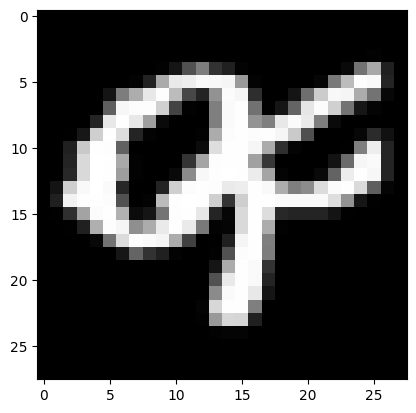

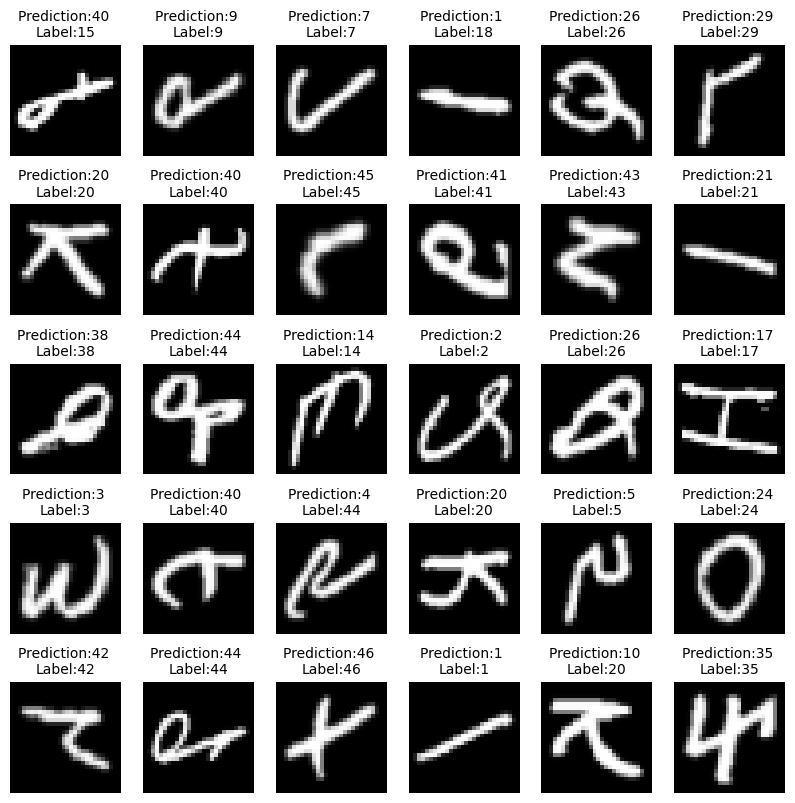

KeyboardInterrupt: 

In [98]:
import random
import time
train_size=len(trainSet)
test_size=len(testSet)

for models in range(1,4):
    modelSelected = modelOptions(models,1)
    model = MLP(modelSelected)

    for optimizers in range(1,4):
        # define learning rate
        learningRate = 0.005
        # define your optimizer and learning rate
        optimizer = optimizerOptions(optimizerChoice = optimizers, learningRate=learningRate)
        # define the loss function
        criterion = nn.CrossEntropyLoss()
        # set the epoch
        epochs = 15

        # Start training
        startTime = time.time()

        # loop over the dataset multiple times
        losses = []
        
        for i in range(epochs):
            for j,(images,targets) in enumerate(trainLoader):
                
                #making predictions
                y_pred = model(images)
            
                #calculating loss
                loss = criterion(y_pred,targets.reshape(-1))
                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if i>10:
                optimizer.lr = 0.0005
            # print(loss)
            losses.append(loss)
        
        endTime = time.time()


        # Testing
        rand_no = random.randint(0,10000)

        x_test,y_test = next(iter(testLoader))

        y_pred = (model(x_test).argmax(dim=1))

        plt.imshow(x_test[rand_no].reshape(28,28),cmap='gray')

        pred = model(x_test[rand_no].reshape(-1,1,28,28)).argmax()

        print("Prediction is {}".format(pred))
        print("Accuracy is : ",(y_pred.eq(y_test).sum()/test_size).item()*100,"%")
        print("Training time is : ", endTime-startTime, 'seconds')
        print('Complete Analysis for model {} optimizer {}'.format(models, optimizers))

        # Visulize some test figures
        figure = plt.figure(figsize=(10, 10))
        cols, rows = 6, 5
        for i in range(1, cols * rows + 1):
            sample_idx = torch.randint(len(testSet), size=(1,)).item()
            # print("Prediction: {}".format(sample_idx))
            img, label = testSet[sample_idx]
            # print(img.shape)
            pred = model(img.reshape(-1,1,28,28)).argmax()
            figure.add_subplot(rows, cols, i)
            # plt.title("Label "+ str(label))
            plt.title("Prediction:{} \nLabel:{}".format(pred, label), fontsize = 10)
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
        plt.show()

Prediction is 44
Accuracy is :  83.27659368515015 %
Training time is :  734.2401156425476 seconds
Complete Analysis for model 1 optimizer 1


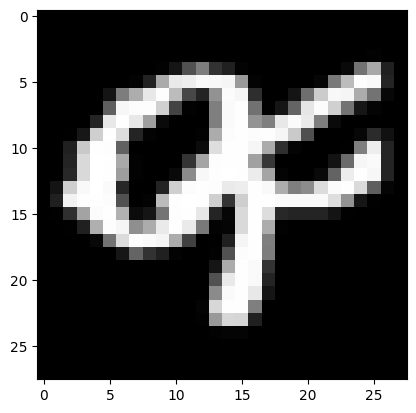

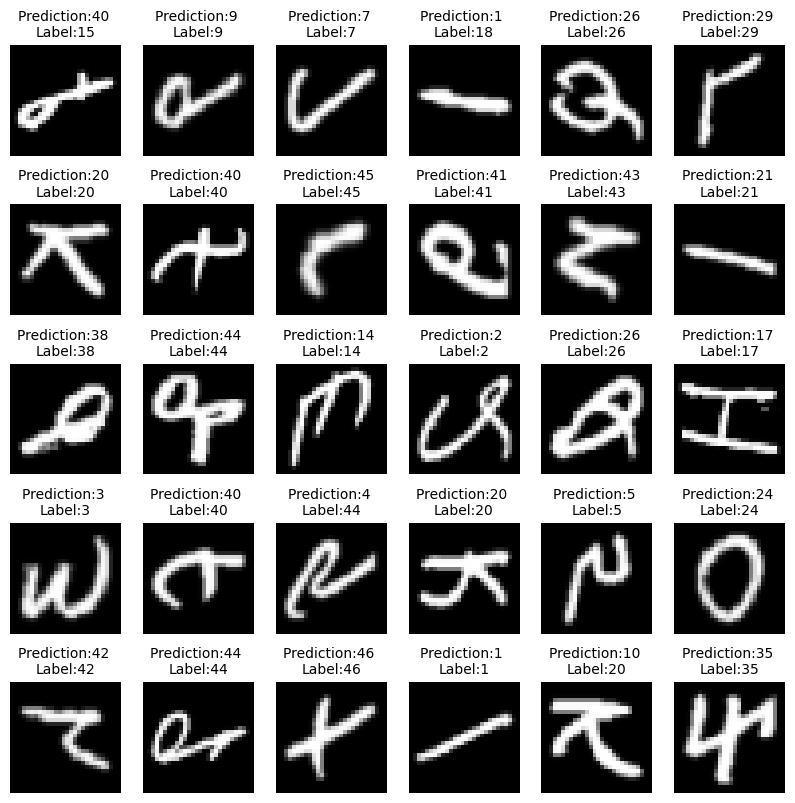

KeyboardInterrupt: 

In [ ]:
import random
import time
train_size=len(trainSet)
test_size=len(testSet)

for models in range(1,4):
    modelSelected = modelOptions(models,1)
    model = MLP(modelSelected)

    for optimizers in range(1,4):
        # define learning rate
        learningRate = 0.005
        # define your optimizer with SGD and learning rate
        optimizer = optimizerOptions(optimizerChoice = optimizers, learningRate=learningRate)
        # define the loss function
        criterion = nn.CrossEntropyLoss()
        # set the epoch
        epochs = 15

        # Start training
        startTime = time.time()

        # loop over the dataset multiple times
        losses = []
        
        for i in range(epochs):
            for j,(images,targets) in enumerate(trainLoader):
                
                #making predictions
                y_pred = model(images)
            
                #calculating loss
                loss = criterion(y_pred,targets.reshape(-1))
                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if i>10:
                optimizer.lr = 0.0005
            # print(loss)
            losses.append(loss)
        
        endTime = time.time()


        # Testing
        rand_no = random.randint(0,10000)

        x_test,y_test = next(iter(testLoader))

        y_pred = (model(x_test).argmax(dim=1))

        plt.imshow(x_test[rand_no].reshape(28,28),cmap='gray')

        pred = model(x_test[rand_no].reshape(-1,1,28,28)).argmax()

        print("Prediction is {}".format(pred))
        print("Accuracy is : ",(y_pred.eq(y_test).sum()/test_size).item()*100,"%")
        print("Training time is : ", endTime-startTime, 'seconds')
        print('Complete Analysis for model {} optimizer {}'.format(models, optimizers))

        # Visulize some test figures
        figure = plt.figure(figsize=(10, 10))
        cols, rows = 6, 5
        for i in range(1, cols * rows + 1):
            sample_idx = torch.randint(len(testSet), size=(1,)).item()
            # print("Prediction: {}".format(sample_idx))
            img, label = testSet[sample_idx]
            # print(img.shape)
            pred = model(img.reshape(-1,1,28,28)).argmax()
            figure.add_subplot(rows, cols, i)
            # plt.title("Label "+ str(label))
            plt.title("Prediction:{} \nLabel:{}".format(pred, label), fontsize = 10)
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
        plt.show()

In [84]:
#  you can set epoch size

# loop over the dataset multiple times
losses = []

for i in range(epochs):
  for j,(images,targets) in enumerate(trainLoader):
    
    #making predictions
    y_pred = model(images)
  
    #calculating loss
    loss = criterion(y_pred,targets.reshape(-1))
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if i>10:
    optimizer.lr = 0.0005
  print(loss)
  losses.append(loss)

print('Complete Training')

tensor(2.4219, grad_fn=<NllLossBackward0>)
tensor(1.6030, grad_fn=<NllLossBackward0>)
tensor(1.4228, grad_fn=<NllLossBackward0>)
tensor(1.2494, grad_fn=<NllLossBackward0>)
tensor(1.1081, grad_fn=<NllLossBackward0>)
tensor(1.0010, grad_fn=<NllLossBackward0>)
tensor(0.9074, grad_fn=<NllLossBackward0>)
tensor(0.8318, grad_fn=<NllLossBackward0>)
tensor(0.7699, grad_fn=<NllLossBackward0>)
tensor(0.7064, grad_fn=<NllLossBackward0>)
tensor(0.6551, grad_fn=<NllLossBackward0>)
tensor(0.6001, grad_fn=<NllLossBackward0>)
tensor(0.5486, grad_fn=<NllLossBackward0>)
tensor(0.5101, grad_fn=<NllLossBackward0>)
tensor(0.4770, grad_fn=<NllLossBackward0>)
Complete Training


4642
Prediction is 12
Accuracy is :  83.23936462402344 %


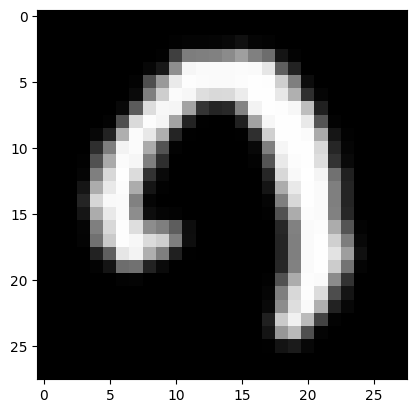

In [85]:
# Test the result on test data

# make a prediction for a sample randomly chose from the test dataset
# you can run this part repeatedly, see the classification result from the model
import random
train_size=len(trainSet)
test_size=len(testSet)
rand_no = random.randint(0,10000)
print(rand_no)

x_test,y_test = next(iter(testLoader))

y_pred = (model(x_test).argmax(dim=1))

plt.imshow(x_test[rand_no].reshape(28,28),cmap='gray')

pred = model(x_test[rand_no].reshape(-1,1,28,28)).argmax()

print("Prediction is {}".format(pred))

# compute the accuracy



# compute the accuracy of the model

print("Accuracy is : ",(y_pred.eq(y_test).sum()/test_size).item()*100,"%")




Prediction: 7498
Prediction: 1105
Prediction: 14233
Prediction: 18740
Prediction: 5309
Prediction: 764
Prediction: 16431
Prediction: 17099
Prediction: 4068
Prediction: 5161
Prediction: 2087
Prediction: 18763
Prediction: 13938
Prediction: 5544
Prediction: 5313
Prediction: 884
Prediction: 15946
Prediction: 5302
Prediction: 2993
Prediction: 2865
Prediction: 17808
Prediction: 17675
Prediction: 15969
Prediction: 10479
Prediction: 6792
Prediction: 17612
Prediction: 4270
Prediction: 8599
Prediction: 6496
Prediction: 905


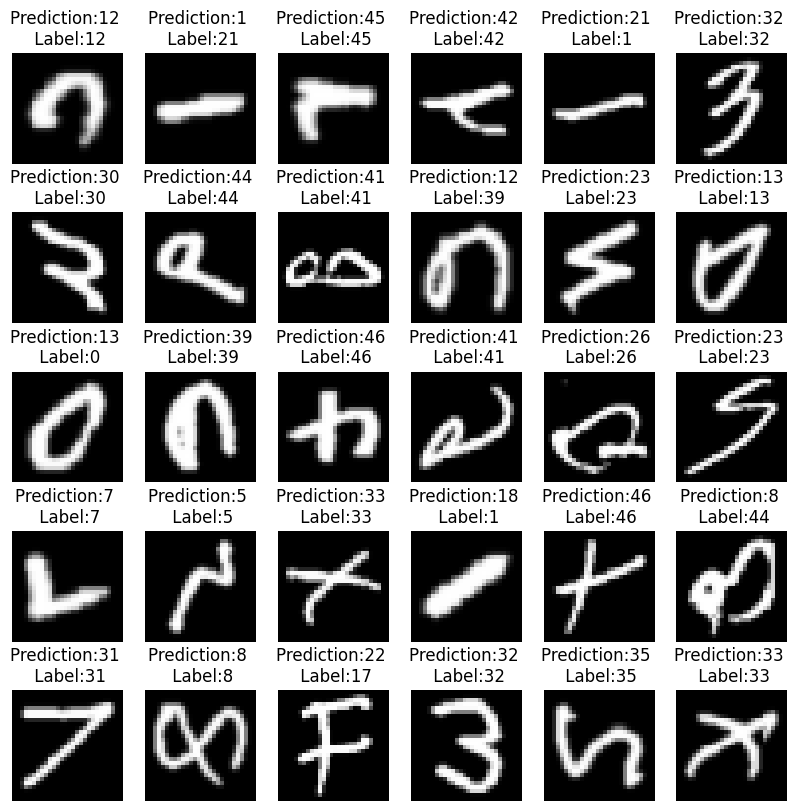

In [93]:
# Visulize some test figures
figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testSet), size=(1,)).item()
    img, label = testSet[sample_idx]
    # print(img.shape)
    pred = model(img.reshape(-1,1,28,28)).argmax()
    figure.add_subplot(rows, cols, i)
    # plt.title("Label "+ str(label))
    plt.title("Prediction:{} \n Label:{}".format(pred, label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [87]:
# define the model
modelSelected = modelOptions(2,1)
model = MLP(modelSelected)
print(model)

# define learning rate
learningRate = 0.005
# define your optimizer with SGD and learning rate
optimizer = optimizerOptions(optimizerChoice = 1, learningRate=learningRate)
# define the loss function
criterion = nn.CrossEntropyLoss()
# set the epoch
epochs = 15


# loop over the dataset multiple times
losses = []

for i in range(epochs):
  for j,(images,targets) in enumerate(trainLoader):
    
    #making predictions
    y_pred = model(images)
  
    #calculating loss
    loss = criterion(y_pred,targets.reshape(-1))
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if i>10:
    optimizer.lr = 0.0005
  print(loss)
  losses.append(loss)

print('Complete Training')

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=47, bias=True)
  )
)
tensor(3.0074, grad_fn=<NllLossBackward0>)
tensor(1.8429, grad_fn=<NllLossBackward0>)
tensor(1.5356, grad_fn=<NllLossBackward0>)
tensor(1.3292, grad_fn=<NllLossBackward0>)
tensor(1.1460, grad_fn=<NllLossBackward0>)
tensor(1.0606, grad_fn=<NllLossBackward0>)
tensor(0.9890, grad_fn=<NllLossBackward0>)
tensor(0.9348, grad_fn=<NllLossBackward0>)
tensor(0.8860, grad_fn=<NllLossBackward0>)
tensor(0.8500, grad_fn=<NllLossBackward0>)
tensor(0.8171, grad_fn=<NllLossBackward0>)
tensor(0.7868, grad_fn=<NllLossBackward0>)
tensor(0.7508, grad_fn=<NllLossBackward0>)
tensor(0.7108, grad_fn=<NllLossBackward0>)
tensor(0.6709, grad_fn=<N

5956
Prediction is 1
Accuracy is :  82.03723430633545 %


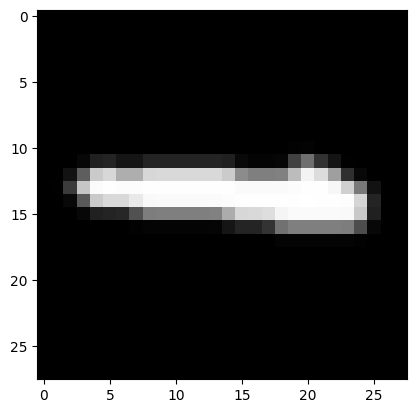

In [88]:
import random
train_size=len(trainSet)
test_size=len(testSet)
rand_no = random.randint(0,10000)
print(rand_no)

x_test,y_test = next(iter(testLoader))

y_pred = (model(x_test).argmax(dim=1))

plt.imshow(x_test[rand_no].reshape(28,28),cmap='gray')

pred = model(x_test[rand_no].reshape(-1,1,28,28)).argmax()

print("Prediction is {}".format(pred))

# compute the accuracy

# compute the accuracy of the model

print("Accuracy is : ",(y_pred.eq(y_test).sum()/test_size).item()*100,"%")

Prediction: 2214
Prediction: 6697
Prediction: 13249
Prediction: 15316
Prediction: 17419
Prediction: 16821
Prediction: 11599
Prediction: 11125
Prediction: 16974
Prediction: 10260
Prediction: 7979
Prediction: 587
Prediction: 12673
Prediction: 8463
Prediction: 1813
Prediction: 2166
Prediction: 15512
Prediction: 1531
Prediction: 10254
Prediction: 9460
Prediction: 205
Prediction: 9035
Prediction: 6848
Prediction: 3013
Prediction: 14204
Prediction: 10507
Prediction: 9464
Prediction: 8544
Prediction: 11783
Prediction: 16678


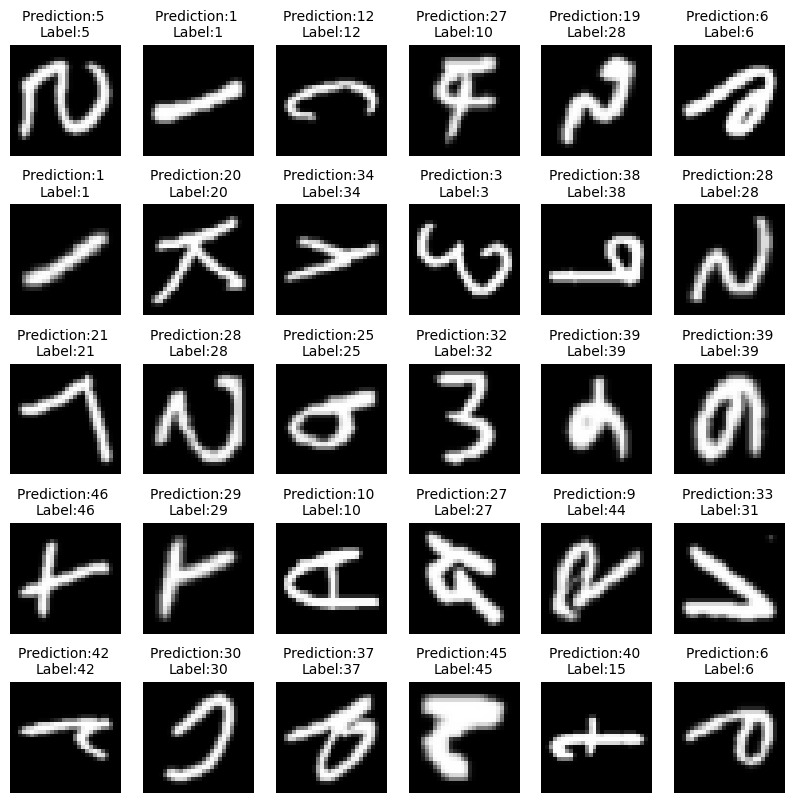

In [92]:
# Visulize some test figures
figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testSet), size=(1,)).item()
    img, label = testSet[sample_idx]
    # print(img.shape)
    pred = model(img.reshape(-1,1,28,28)).argmax()
    figure.add_subplot(rows, cols, i)
    # plt.title("Label "+ str(label))
    plt.title("Prediction:{} \nLabel:{}".format(pred, label), fontsize = 10)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Prediction is 17
Accuracy is :  83.30851197242737 %
Complete Analysis for model 1 optimizer 1


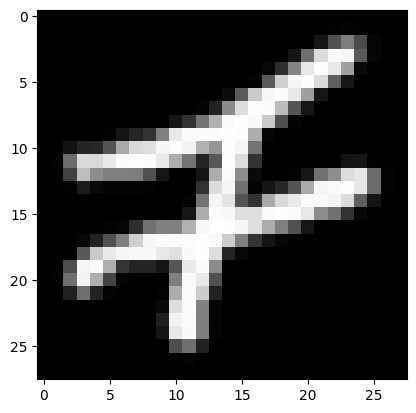

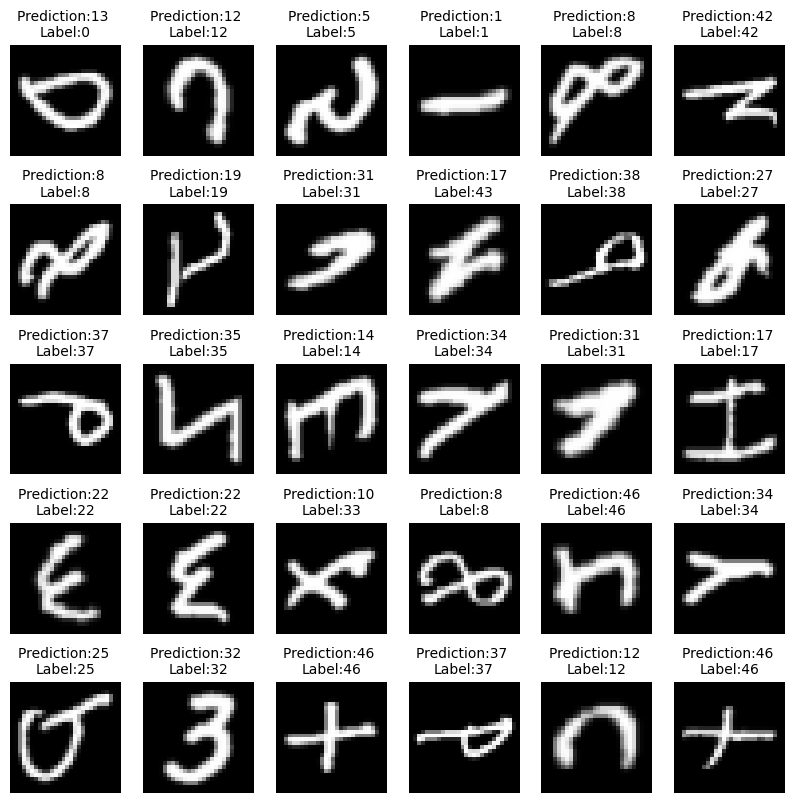

Prediction is 46
Accuracy is :  68.3297872543335 %
Complete Analysis for model 1 optimizer 2


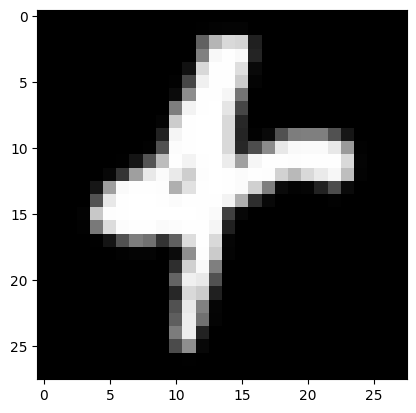

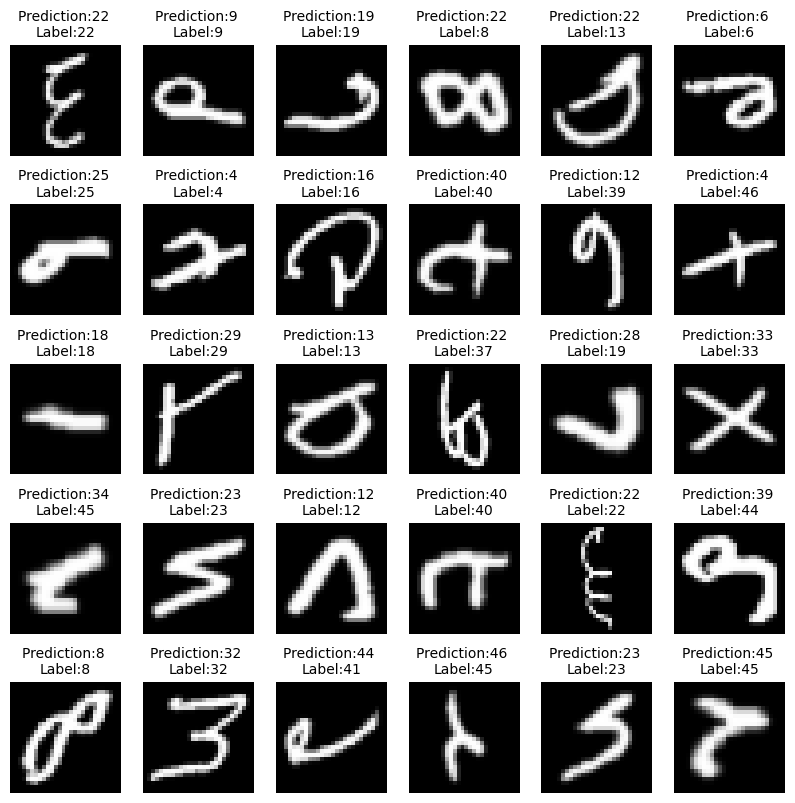

Prediction is 8
Accuracy is :  2.771276608109474 %
Complete Analysis for model 1 optimizer 3


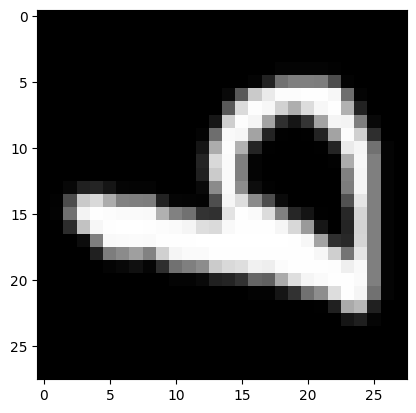

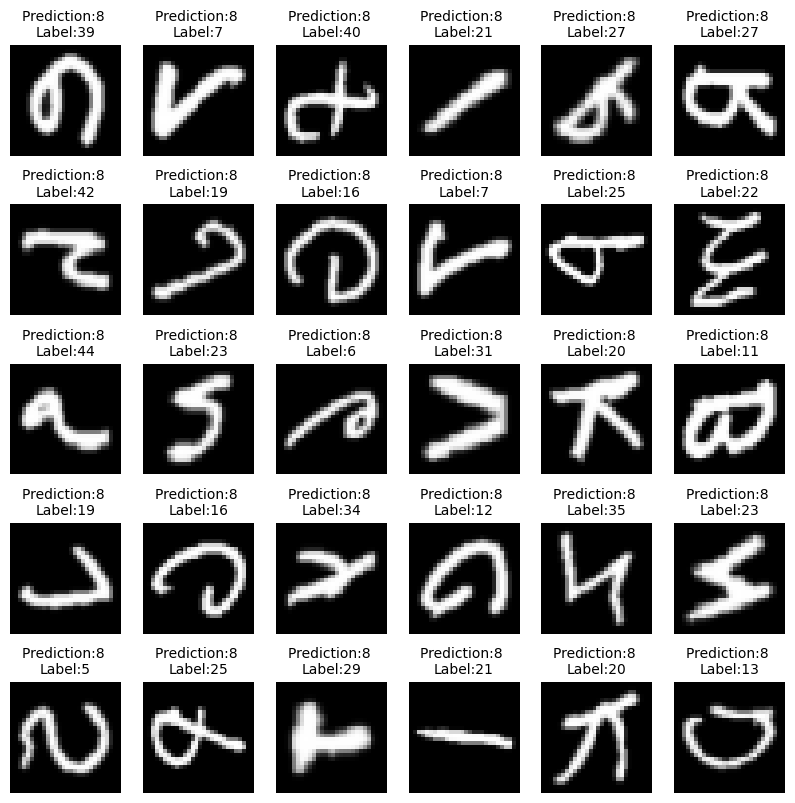

Prediction is 30
Accuracy is :  82.10106492042542 %
Complete Analysis for model 2 optimizer 1


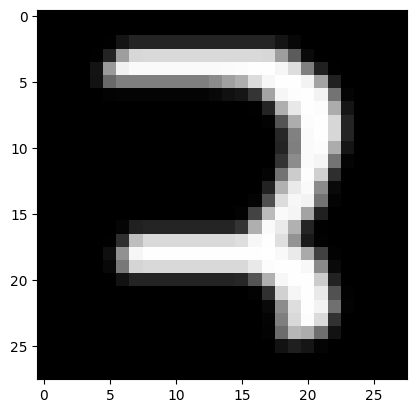

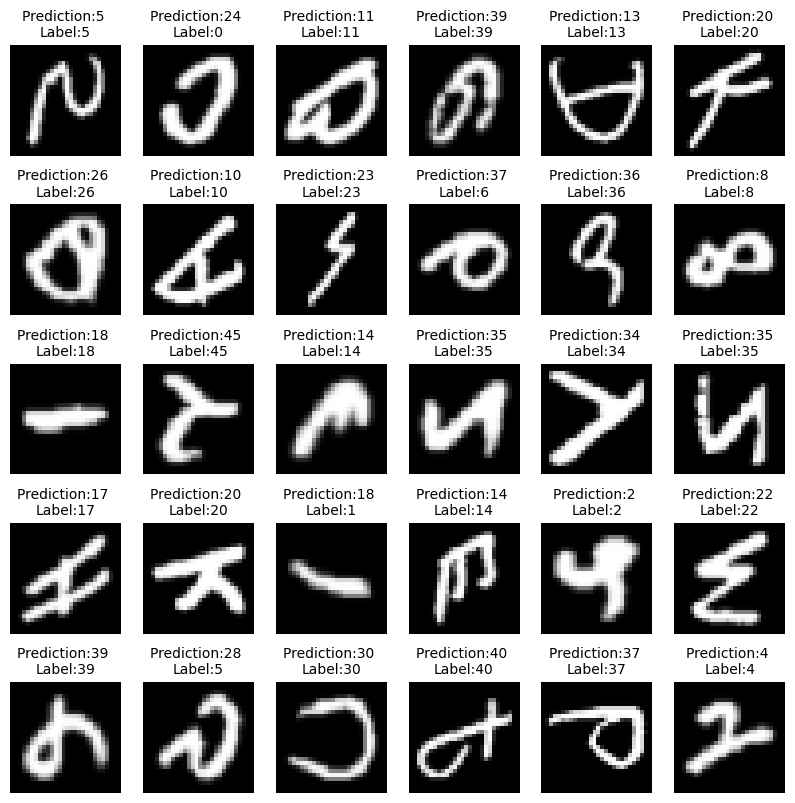

Prediction is 35
Accuracy is :  75.30850768089294 %
Complete Analysis for model 2 optimizer 2


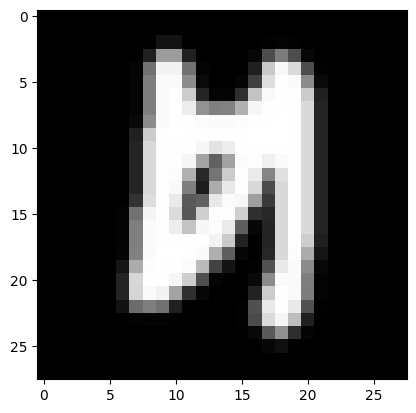

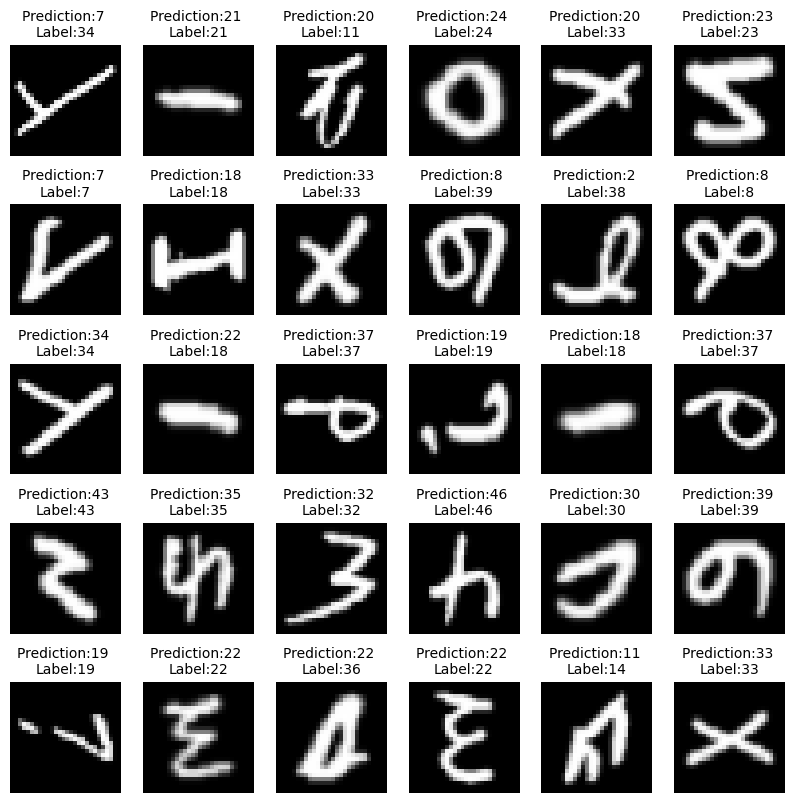

Prediction is 1
Accuracy is :  51.23404264450073 %
Complete Analysis for model 2 optimizer 3


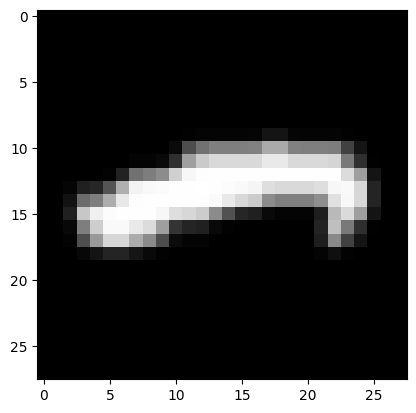

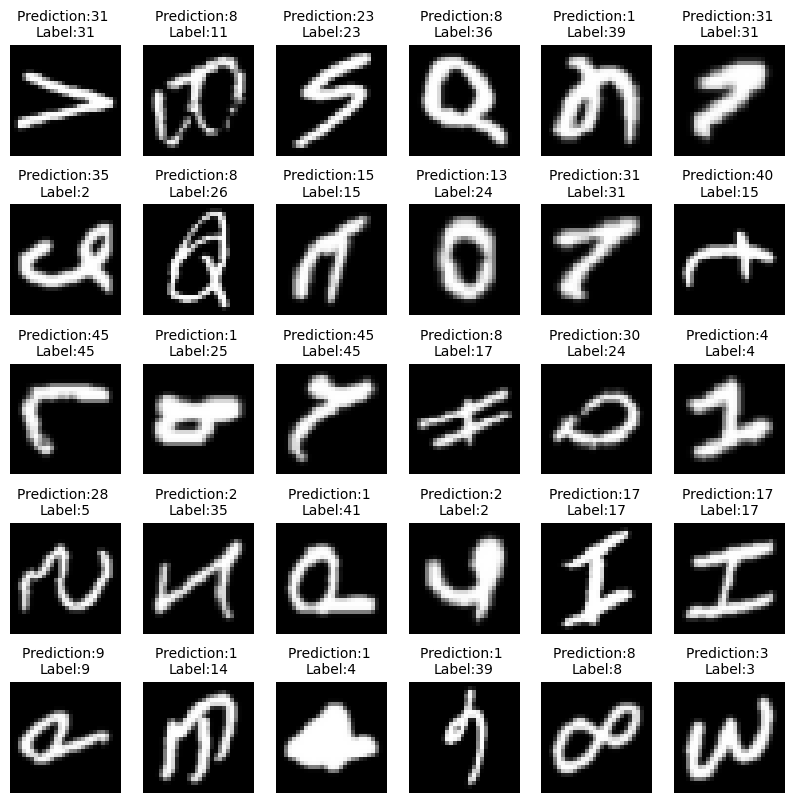

Prediction is 17
Accuracy is :  82.59042501449585 %
Complete Analysis for model 3 optimizer 1


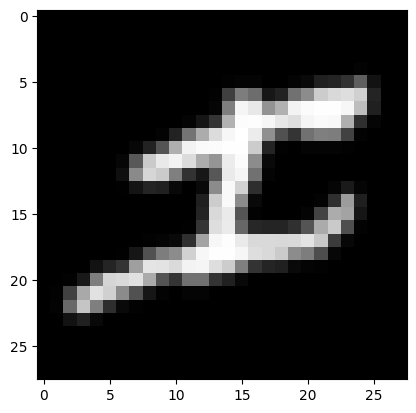

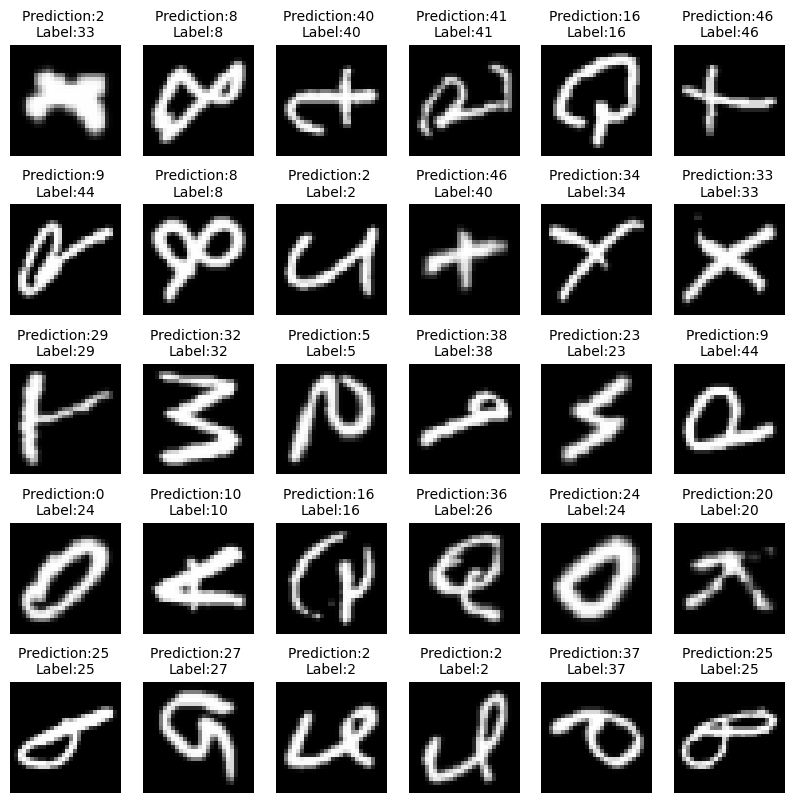

Prediction is 45
Accuracy is :  74.78723526000977 %
Complete Analysis for model 3 optimizer 2


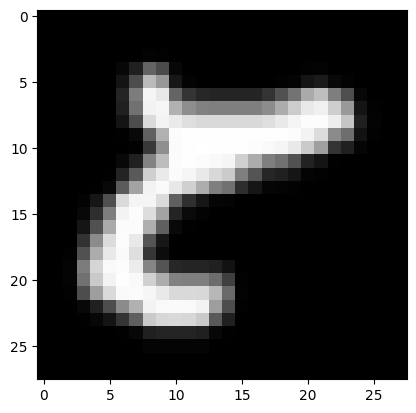

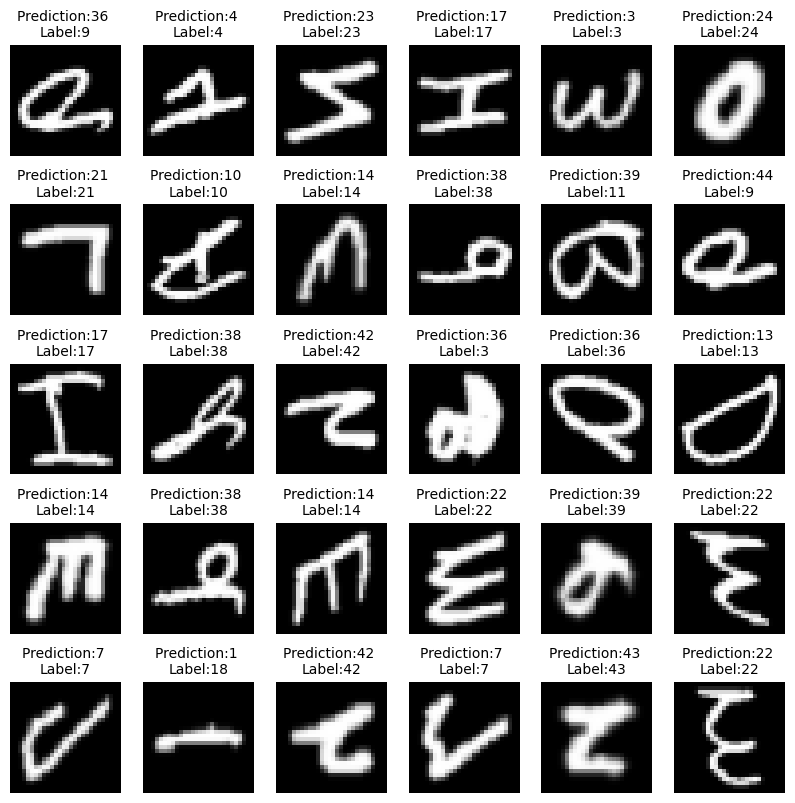

Prediction is 8
Accuracy is :  5.760638415813446 %
Complete Analysis for model 3 optimizer 3


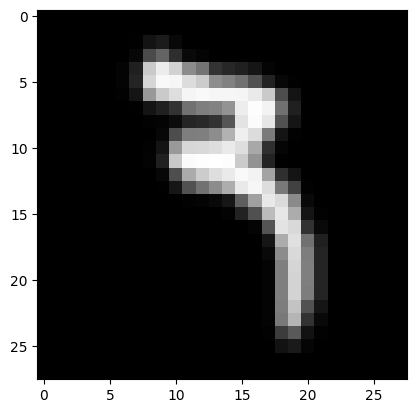

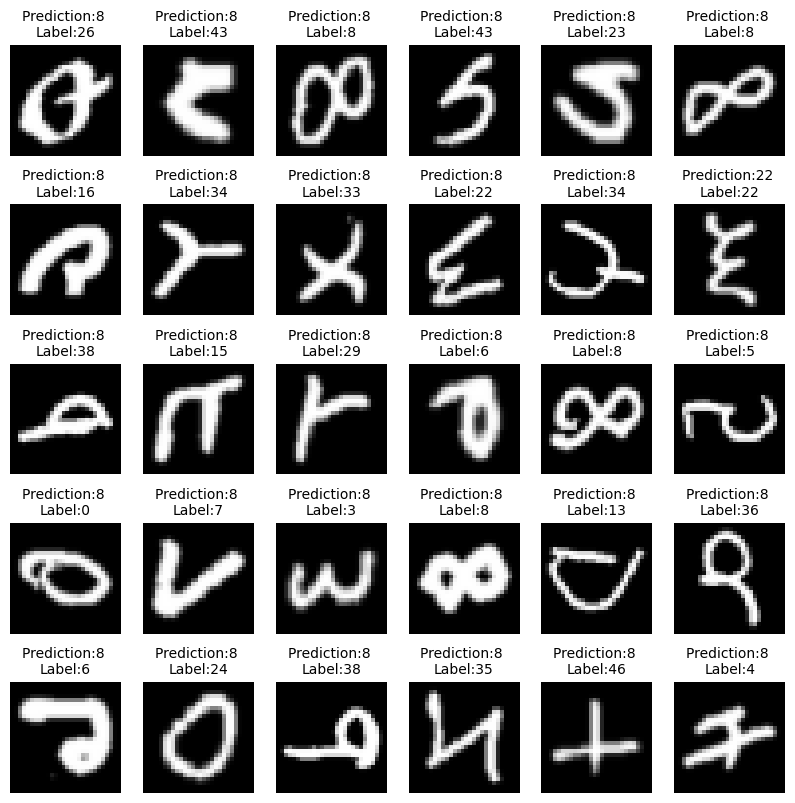

In [95]:
import random
train_size=len(trainSet)
test_size=len(testSet)

for models in range(1,4):
    modelSelected = modelOptions(models,1)
    model = MLP(modelSelected)

    for optimizers in range(1,4):
        # define learning rate
        learningRate = 0.005
        # define your optimizer with SGD and learning rate
        optimizer = optimizerOptions(optimizerChoice = optimizers, learningRate=learningRate)
        # define the loss function
        criterion = nn.CrossEntropyLoss()
        # set the epoch
        epochs = 15

        # loop over the dataset multiple times
        losses = []

        for i in range(epochs):
            for j,(images,targets) in enumerate(trainLoader):
                
                #making predictions
                y_pred = model(images)
            
                #calculating loss
                loss = criterion(y_pred,targets.reshape(-1))
                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if i>10:
                optimizer.lr = 0.0005
            # print(loss)
            losses.append(loss)

        rand_no = random.randint(0,10000)

        x_test,y_test = next(iter(testLoader))

        y_pred = (model(x_test).argmax(dim=1))

        plt.imshow(x_test[rand_no].reshape(28,28),cmap='gray')

        pred = model(x_test[rand_no].reshape(-1,1,28,28)).argmax()

        print("Prediction is {}".format(pred))
        print("Accuracy is : ",(y_pred.eq(y_test).sum()/test_size).item()*100,"%")

        print('Complete Analysis for model {} optimizer {}'.format(models, optimizers))

        # Visulize some test figures
        figure = plt.figure(figsize=(10, 10))
        cols, rows = 6, 5
        for i in range(1, cols * rows + 1):
            sample_idx = torch.randint(len(testSet), size=(1,)).item()
            # print("Prediction: {}".format(sample_idx))
            img, label = testSet[sample_idx]
            # print(img.shape)
            pred = model(img.reshape(-1,1,28,28)).argmax()
            figure.add_subplot(rows, cols, i)
            # plt.title("Label "+ str(label))
            plt.title("Prediction:{} \nLabel:{}".format(pred, label), fontsize = 10)
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
        plt.show()

Prediction is 24
Accuracy is :  3.952127695083618 %
Complete Analysis for model 1 optimizer 1


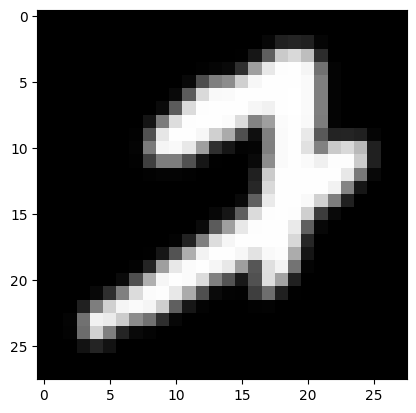

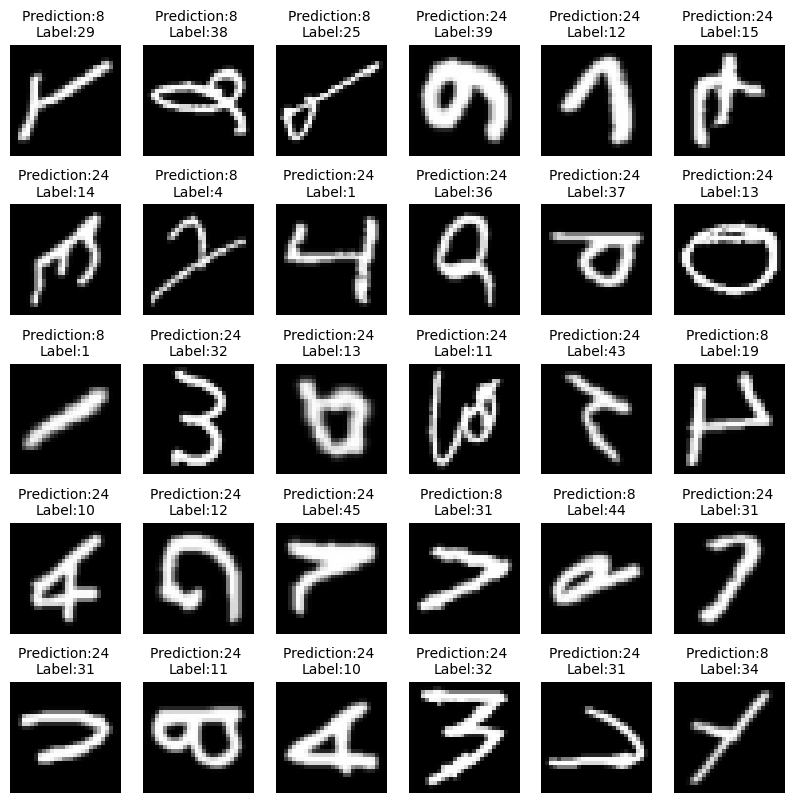

Prediction is 20
Accuracy is :  2.1276595070958138 %
Complete Analysis for model 1 optimizer 2


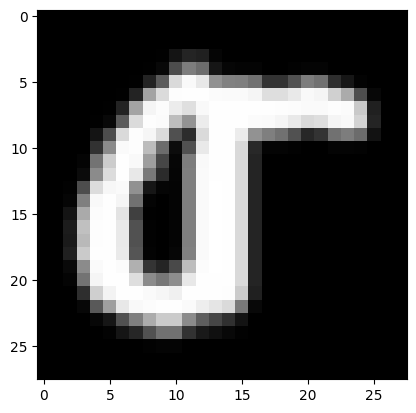

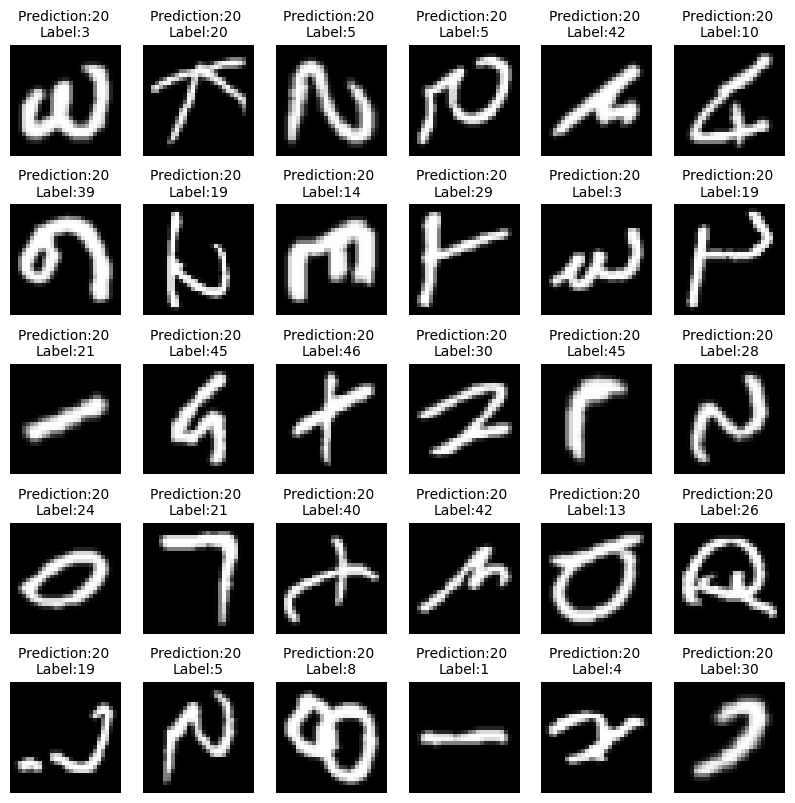

Prediction is 20
Accuracy is :  2.1276595070958138 %
Complete Analysis for model 1 optimizer 3


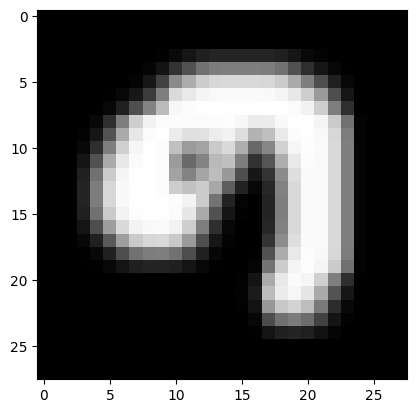

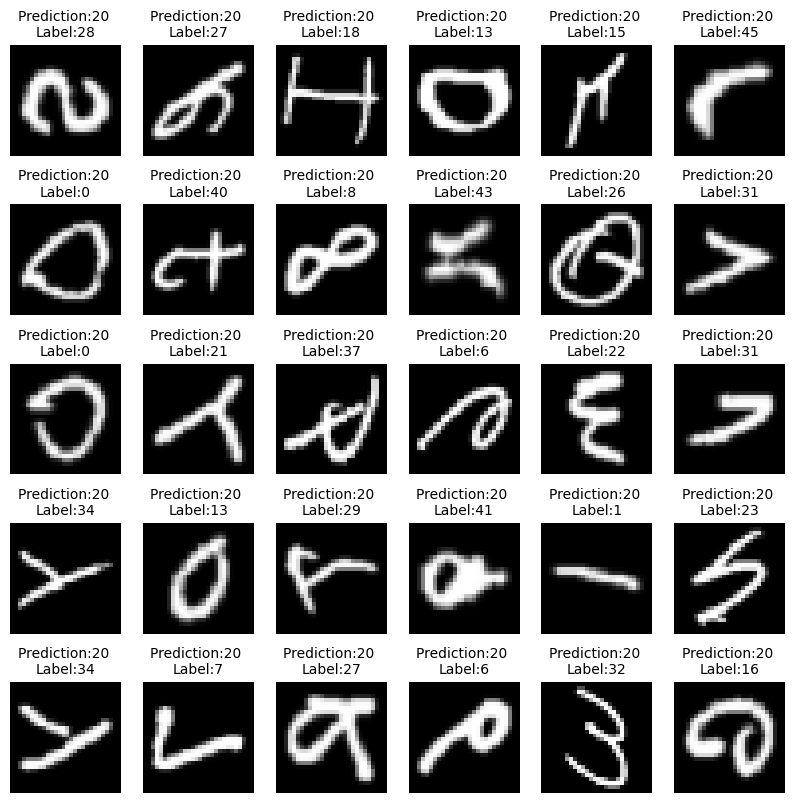

Prediction is 5
Accuracy is :  2.2712765261530876 %
Complete Analysis for model 2 optimizer 1


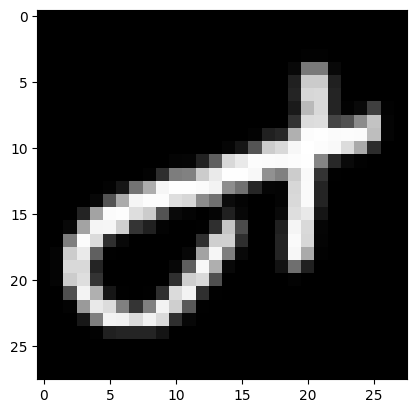

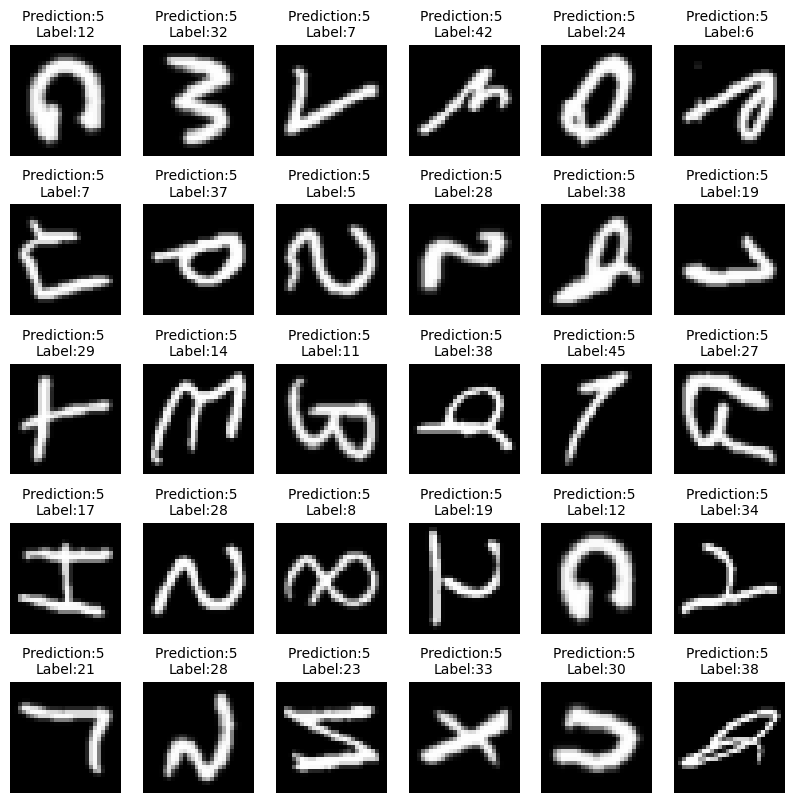

Prediction is 18
Accuracy is :  2.1276595070958138 %
Complete Analysis for model 2 optimizer 2


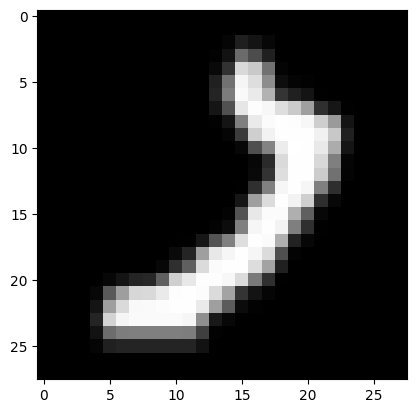

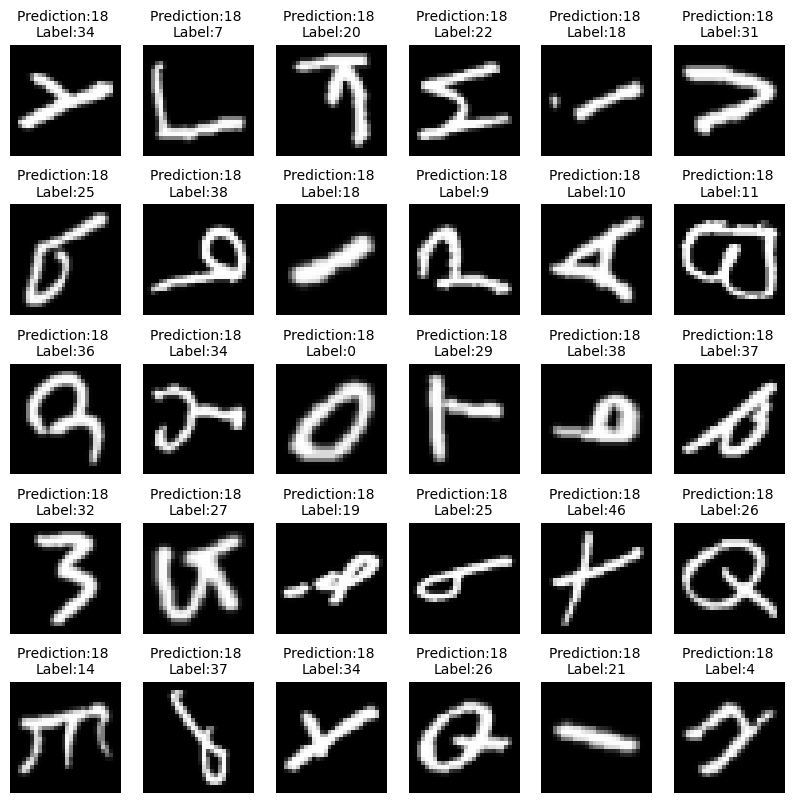

Prediction is 18
Accuracy is :  2.1276595070958138 %
Complete Analysis for model 2 optimizer 3


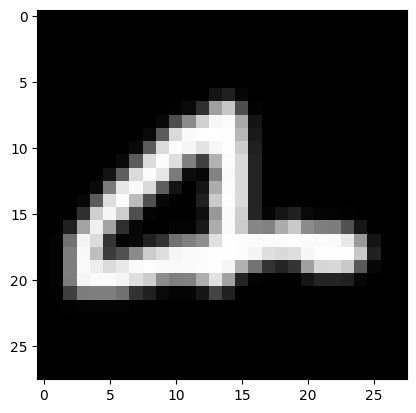

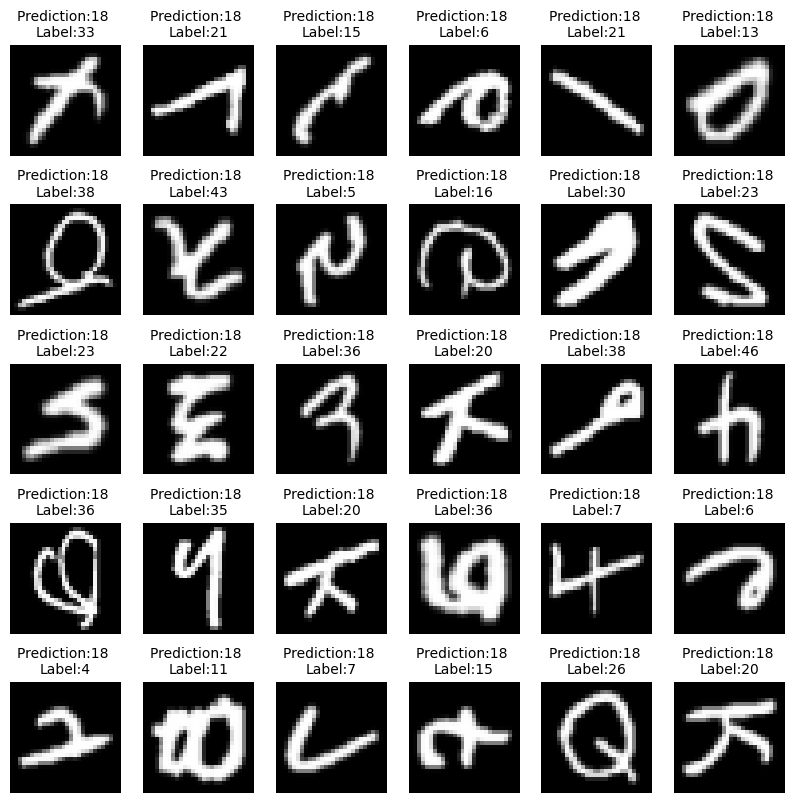

Prediction is 1
Accuracy is :  6.239361688494682 %
Complete Analysis for model 3 optimizer 1


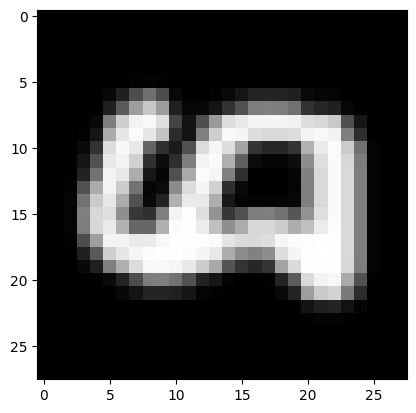

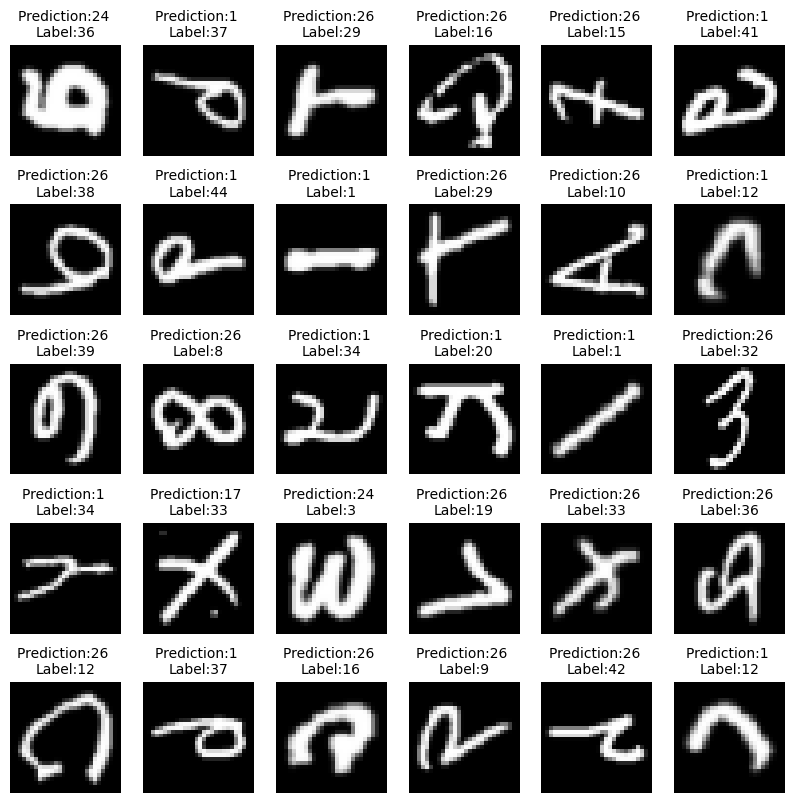

Prediction is 29
Accuracy is :  2.1276595070958138 %
Complete Analysis for model 3 optimizer 2


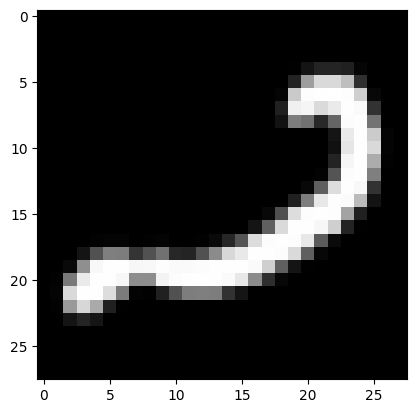

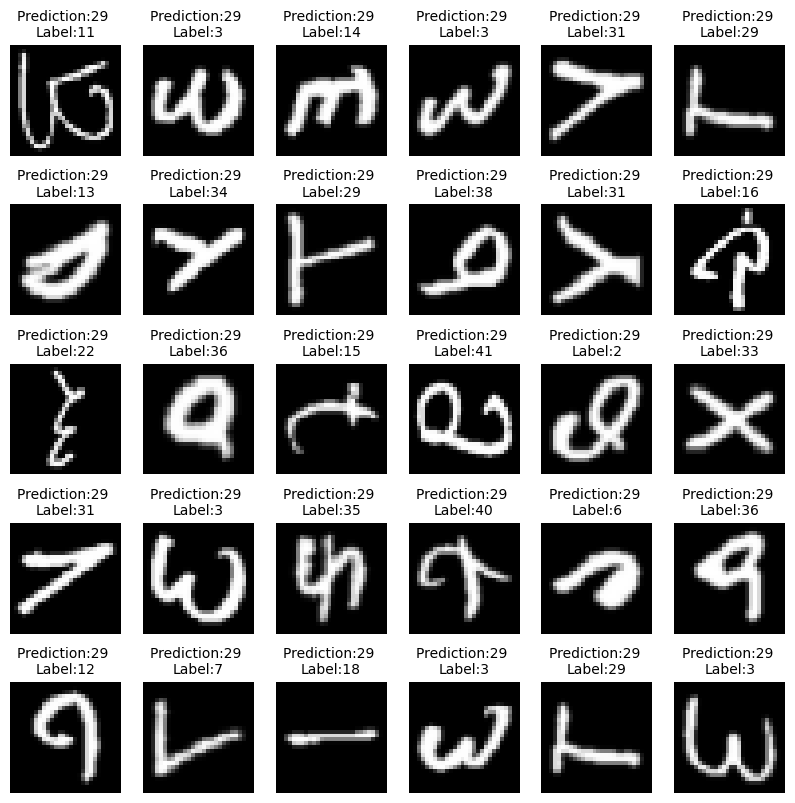

Prediction is 29
Accuracy is :  2.1276595070958138 %
Complete Analysis for model 3 optimizer 3


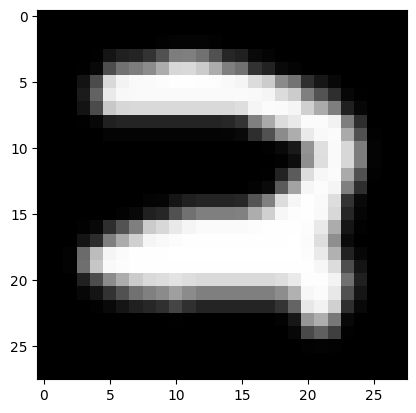

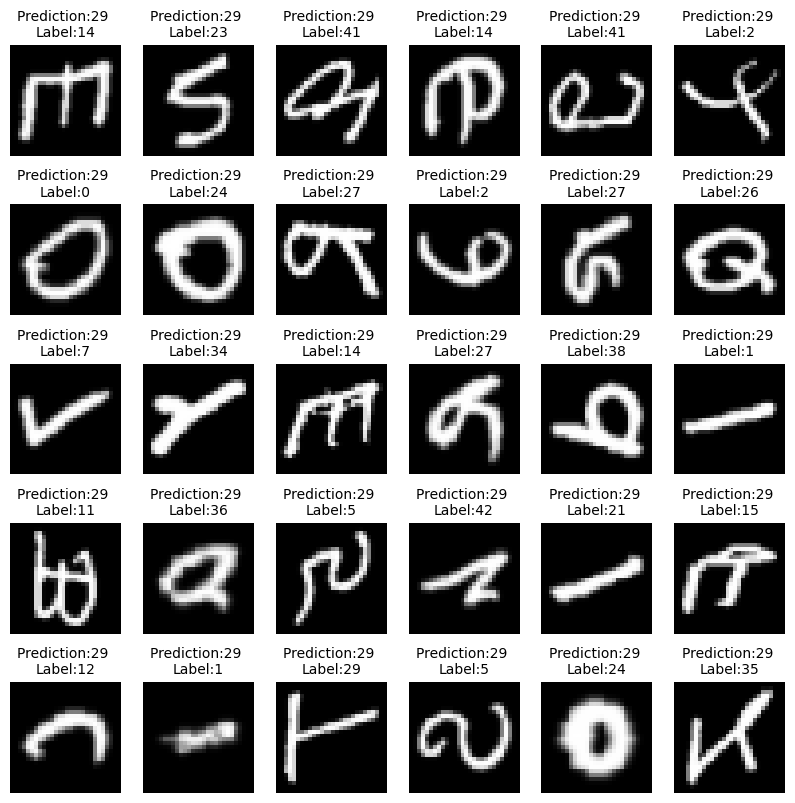

In [96]:
import random
train_size=len(trainSet)
test_size=len(testSet)

for models in range(1,4):
    modelSelected = modelOptions(models,2)
    model = MLP(modelSelected)

    for optimizers in range(1,4):
        # define learning rate
        learningRate = 0.005
        # define your optimizer with SGD and learning rate
        optimizer = optimizerOptions(optimizerChoice = optimizers, learningRate=learningRate)
        # define the loss function
        criterion = nn.CrossEntropyLoss()
        # set the epoch
        epochs = 15

        # loop over the dataset multiple times
        losses = []

        for i in range(epochs):
            for j,(images,targets) in enumerate(trainLoader):
                
                #making predictions
                y_pred = model(images)
            
                #calculating loss
                loss = criterion(y_pred,targets.reshape(-1))
                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if i>10:
                optimizer.lr = 0.0005
            # print(loss)
            losses.append(loss)

        rand_no = random.randint(0,10000)

        x_test,y_test = next(iter(testLoader))

        y_pred = (model(x_test).argmax(dim=1))

        plt.imshow(x_test[rand_no].reshape(28,28),cmap='gray')

        pred = model(x_test[rand_no].reshape(-1,1,28,28)).argmax()

        print("Prediction is {}".format(pred))
        print("Accuracy is : ",(y_pred.eq(y_test).sum()/test_size).item()*100,"%")

        print('Complete Analysis for model {} optimizer {}'.format(models, optimizers))

        # Visulize some test figures
        figure = plt.figure(figsize=(10, 10))
        cols, rows = 6, 5
        for i in range(1, cols * rows + 1):
            sample_idx = torch.randint(len(testSet), size=(1,)).item()
            # print("Prediction: {}".format(sample_idx))
            img, label = testSet[sample_idx]
            # print(img.shape)
            pred = model(img.reshape(-1,1,28,28)).argmax()
            figure.add_subplot(rows, cols, i)
            # plt.title("Label "+ str(label))
            plt.title("Prediction:{} \nLabel:{}".format(pred, label), fontsize = 10)
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
        plt.show()

Prediction is 11
Accuracy is :  76.56915187835693 %
Complete Analysis for model 1 optimizer 1


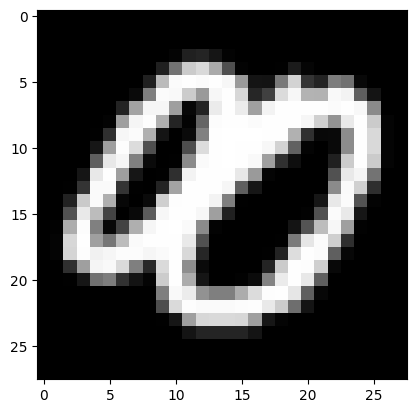

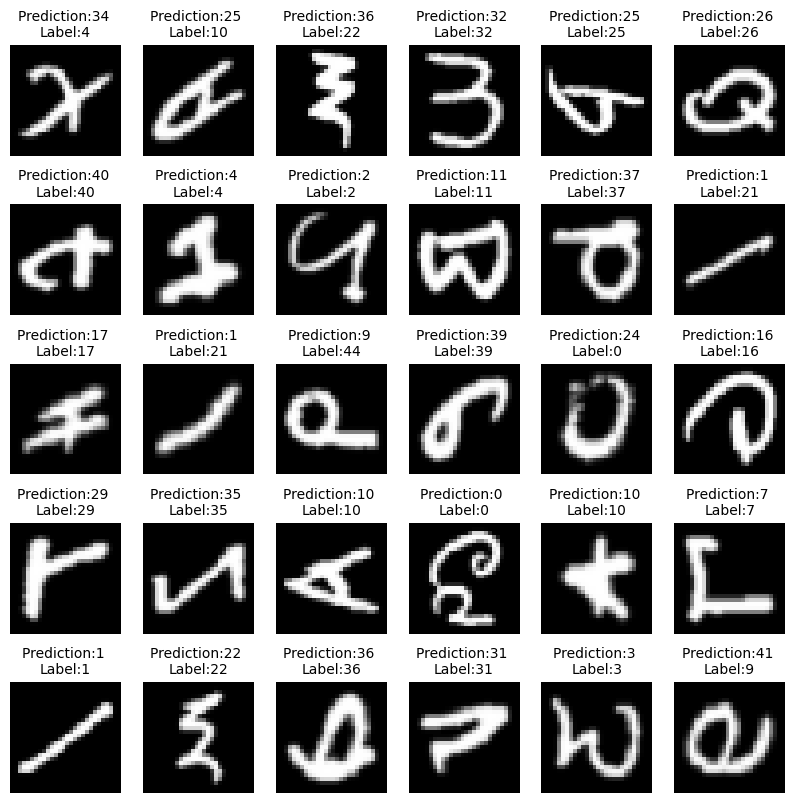

Prediction is 38
Accuracy is :  23.420213162899017 %
Complete Analysis for model 1 optimizer 2


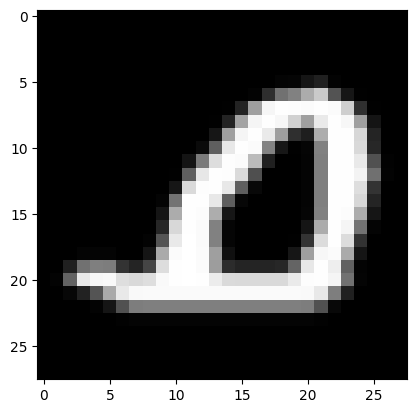

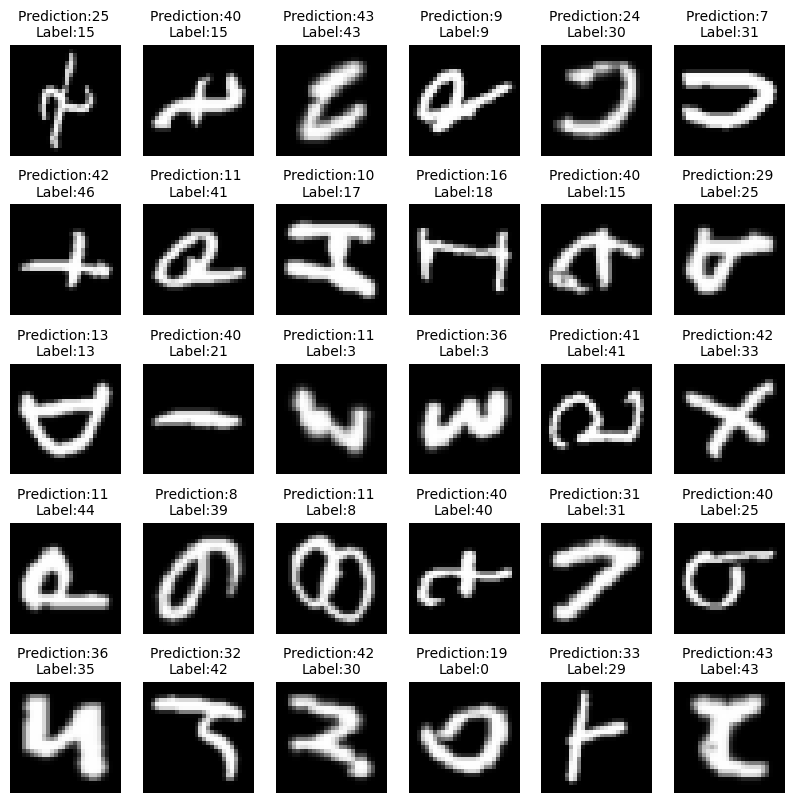

Prediction is 39
Accuracy is :  35.57446897029877 %
Complete Analysis for model 1 optimizer 3


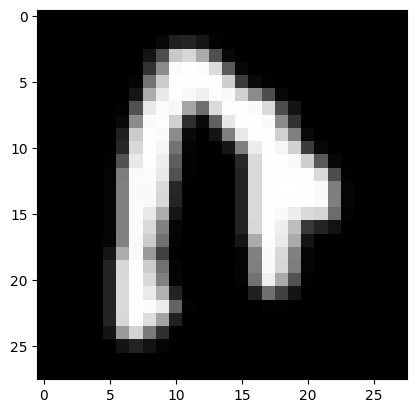

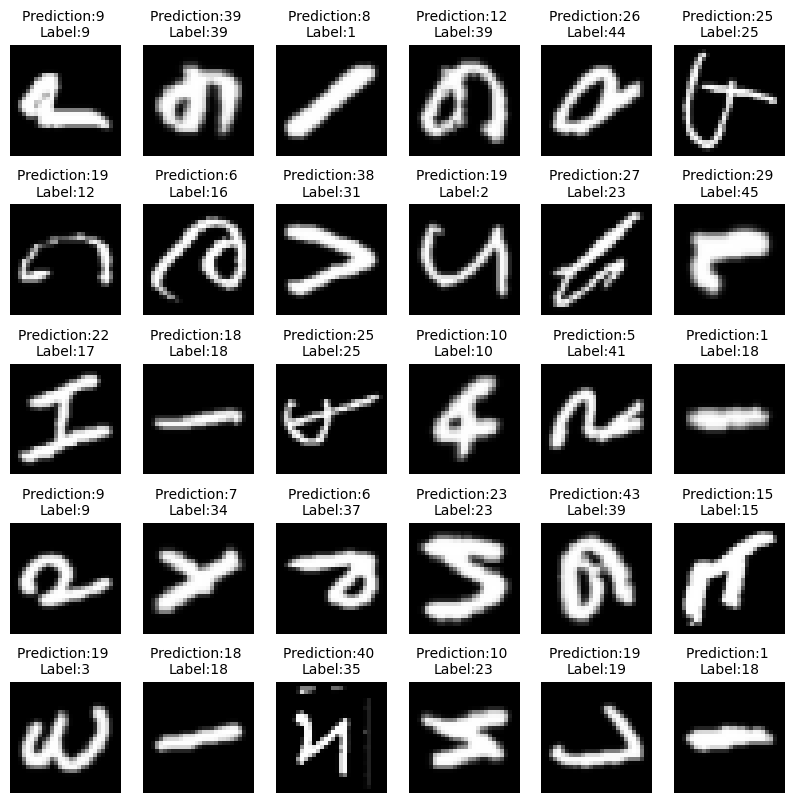

Prediction is 21
Accuracy is :  73.07446599006653 %
Complete Analysis for model 2 optimizer 1


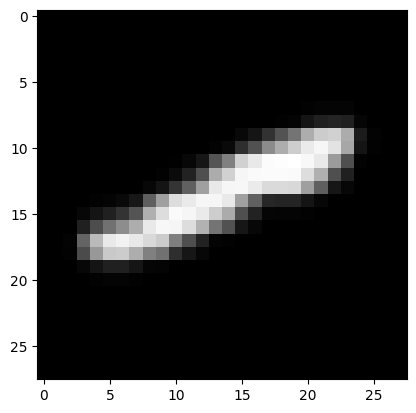

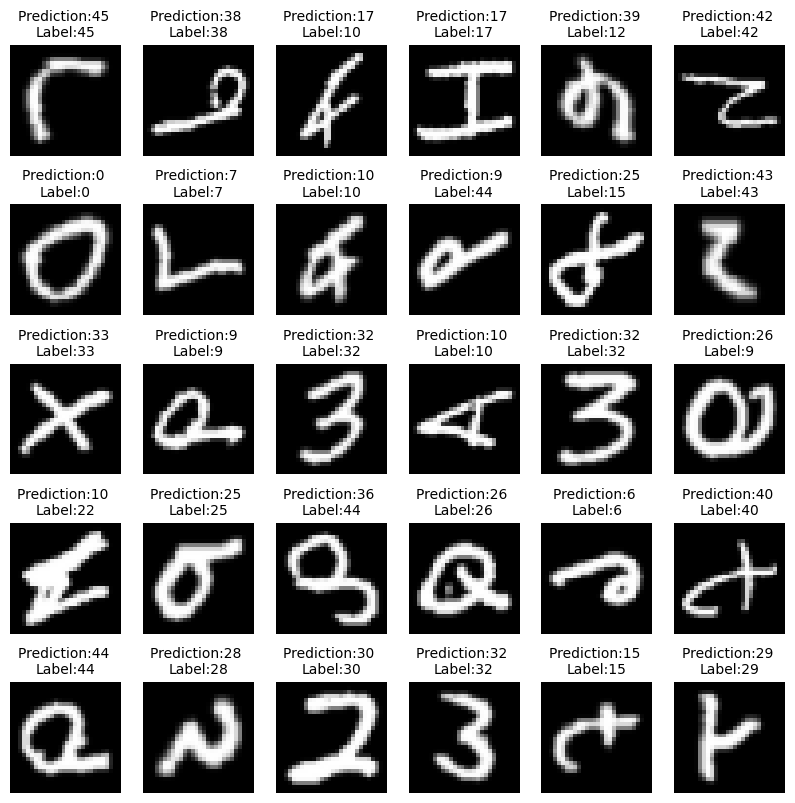

Prediction is 31
Accuracy is :  50.60638189315796 %
Complete Analysis for model 2 optimizer 2


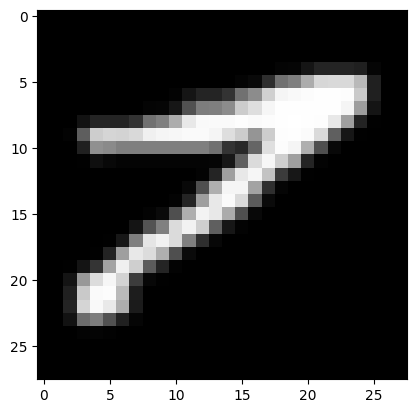

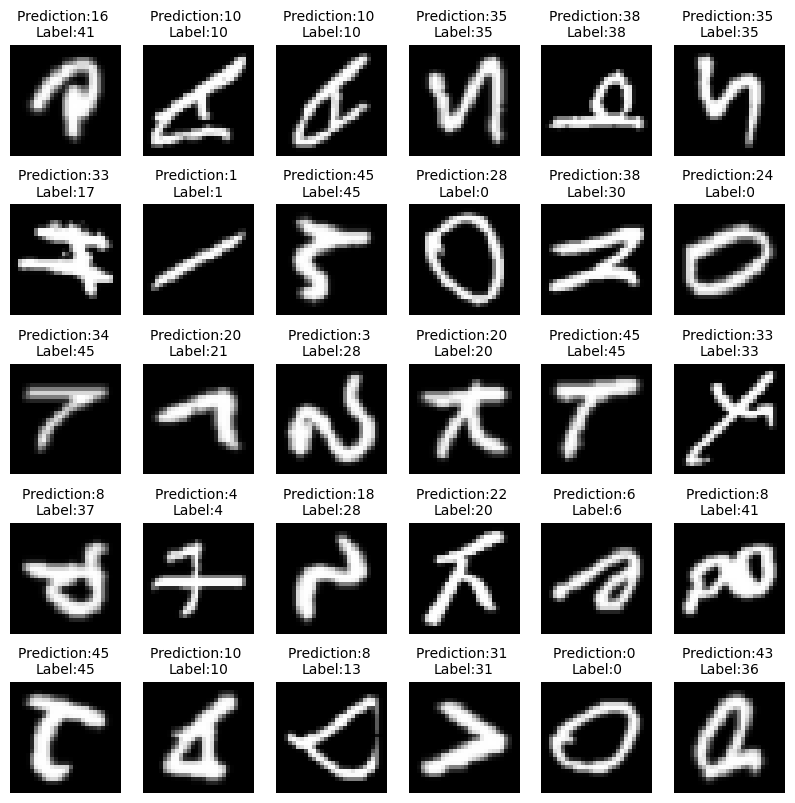

Prediction is 13
Accuracy is :  56.20744824409485 %
Complete Analysis for model 2 optimizer 3


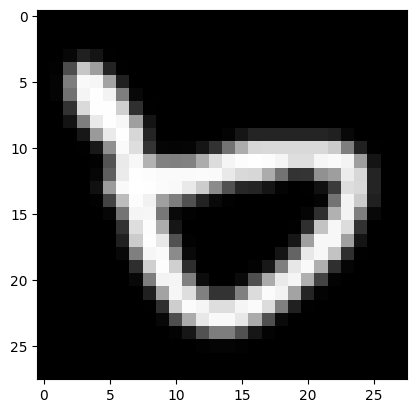

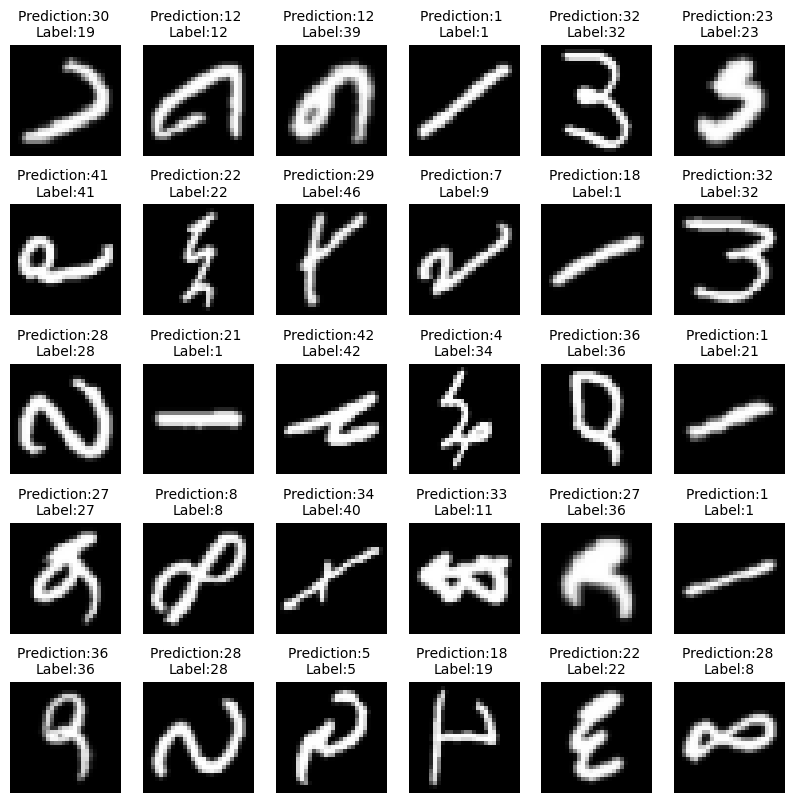

Prediction is 22
Accuracy is :  74.30850863456726 %
Complete Analysis for model 3 optimizer 1


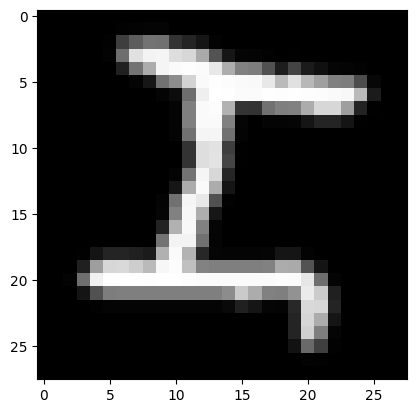

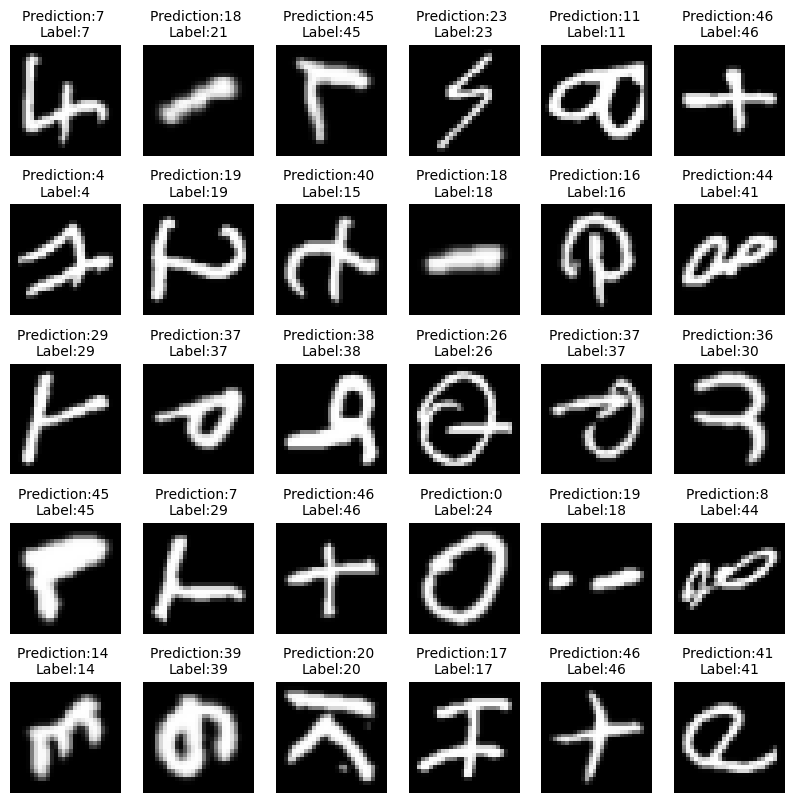

Prediction is 38
Accuracy is :  42.02127754688263 %
Complete Analysis for model 3 optimizer 2


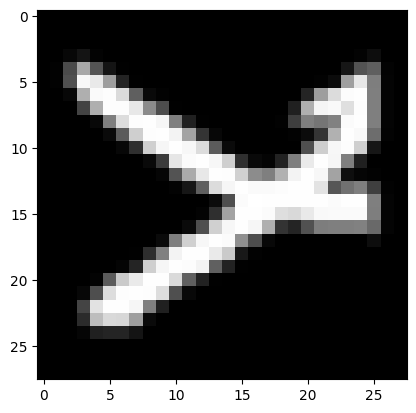

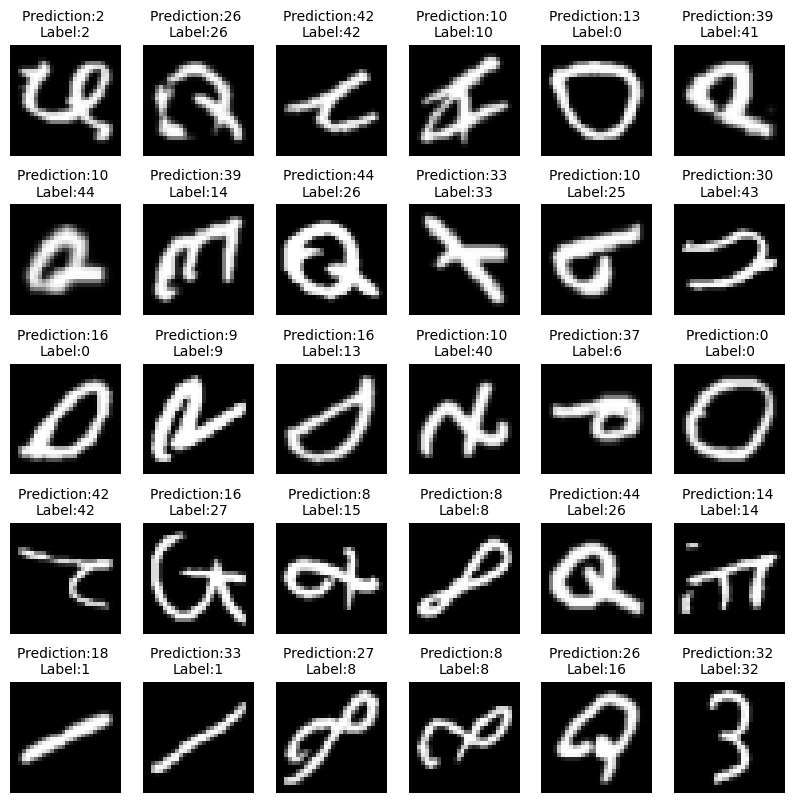

Prediction is 11
Accuracy is :  45.648935437202454 %
Complete Analysis for model 3 optimizer 3


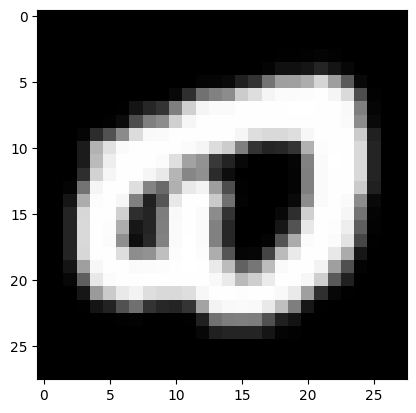

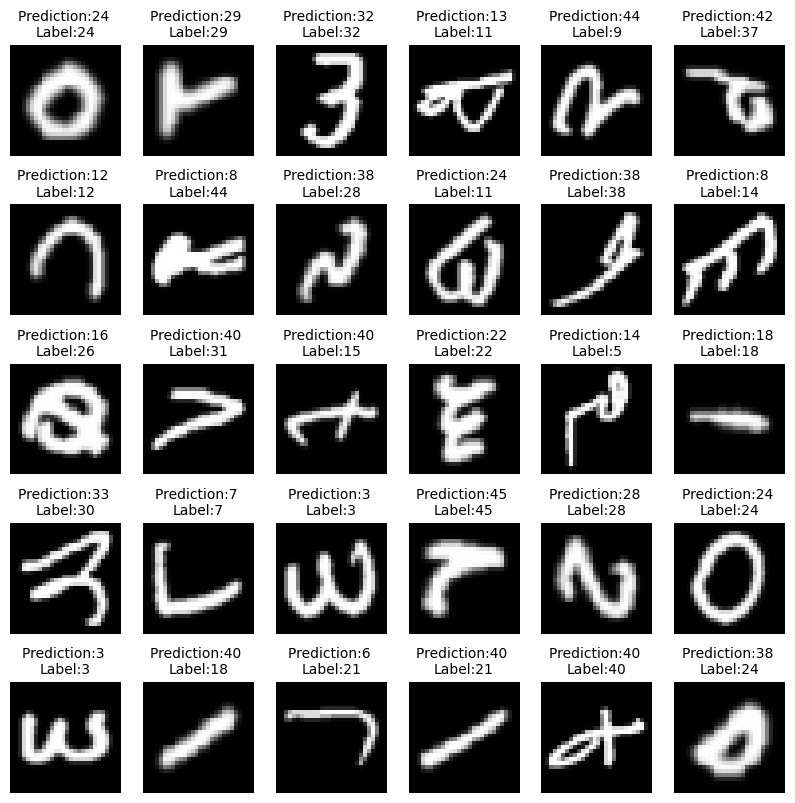

In [97]:
import random
train_size=len(trainSet)
test_size=len(testSet)

for models in range(1,4):
    modelSelected = modelOptions(models,3)
    model = MLP(modelSelected)

    for optimizers in range(1,4):
        # define learning rate
        learningRate = 0.005
        # define your optimizer with SGD and learning rate
        optimizer = optimizerOptions(optimizerChoice = optimizers, learningRate=learningRate)
        # define the loss function
        criterion = nn.CrossEntropyLoss()
        # set the epoch
        epochs = 15

        # loop over the dataset multiple times
        losses = []

        for i in range(epochs):
            for j,(images,targets) in enumerate(trainLoader):
                
                #making predictions
                y_pred = model(images)
            
                #calculating loss
                loss = criterion(y_pred,targets.reshape(-1))
                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if i>10:
                optimizer.lr = 0.0005
            # print(loss)
            losses.append(loss)

        rand_no = random.randint(0,10000)

        x_test,y_test = next(iter(testLoader))

        y_pred = (model(x_test).argmax(dim=1))

        plt.imshow(x_test[rand_no].reshape(28,28),cmap='gray')

        pred = model(x_test[rand_no].reshape(-1,1,28,28)).argmax()

        print("Prediction is {}".format(pred))
        print("Accuracy is : ",(y_pred.eq(y_test).sum()/test_size).item()*100,"%")

        print('Complete Analysis for model {} optimizer {}'.format(models, optimizers))

        # Visulize some test figures
        figure = plt.figure(figsize=(10, 10))
        cols, rows = 6, 5
        for i in range(1, cols * rows + 1):
            sample_idx = torch.randint(len(testSet), size=(1,)).item()
            # print("Prediction: {}".format(sample_idx))
            img, label = testSet[sample_idx]
            # print(img.shape)
            pred = model(img.reshape(-1,1,28,28)).argmax()
            figure.add_subplot(rows, cols, i)
            # plt.title("Label "+ str(label))
            plt.title("Prediction:{} \nLabel:{}".format(pred, label), fontsize = 10)
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
        plt.show()